In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os, time, stat, io
from scipy.stats import gamma, norm
from sklearn.linear_model import LinearRegression
plt.style.use('fivethirtyeight')

# Model Notes
- Questions
    - How will we know if the lock down is working? early signals from acceleration in hospitalization
    
- Things to do with cohort model:
    - Compliance levels
    - Monte carlo
    - vary hospital duration by icu/non-icu
    - vary asymptomatic transmission vs symptomatic
    - Add recovered line
    - functionalize charts
    - Functionalize the mortality rate by hospital capacity.

# Data Ingestion

## Bring in county reporting data

In [133]:
raw_reporting = pd.read_csv('https://github.com/nytimes/covid-19-data/raw/master/us-counties.csv')
df_reporting = raw_reporting
df_reporting['dt'] = pd.to_datetime(df_reporting.date)
df_reporting = df_reporting.set_index(['dt','state','county']).sort_index()
df_reporting.reorder_levels([1,2,0]).loc[['New York']].tail()

date     fips  cases  deaths
state    county      dt                                            
New York Washington  2020-04-07  2020-04-07  36115.0     19       1
         Wayne       2020-04-07  2020-04-07  36117.0     35       0
         Westchester 2020-04-07  2020-04-07  36119.0  14804     304
         Wyoming     2020-04-07  2020-04-07  36121.0     23       1
         Yates       2020-04-07  2020-04-07  36123.0      2       0

In [134]:
df_reporting_fmt = pd.DataFrame()
for col in ['cases','deaths']:
    df_tmp = pd.DataFrame()
    df_tmp['NYC'] = df_reporting[col].unstack([1,2])['New York']['New York City'].fillna(0)
    df_tmp['NYS'] = df_reporting[col].unstack([1,2])['New York'].sum(axis=1).fillna(0)
    df_reporting_fmt[col] = df_tmp.stack()
df_reporting_fmt = df_reporting_fmt.unstack()
df_reporting_fmt.tail()


cases            deaths        
                NYC       NYS     NYC     NYS
dt                                           
2020-04-03  57160.0  102945.0  1867.0  2935.0
2020-04-04  63307.0  114996.0  2254.0  3568.0
2020-04-05  67552.0  122911.0  2472.0  4161.0
2020-04-06  68776.0  130703.0  3485.0  5505.0
2020-04-07  76876.0  140081.0  4009.0  5563.0

In [135]:
df_reporting_fmt['NYC_case_share'] = df_reporting_fmt['cases']['NYC']/df_reporting_fmt['cases']['NYS']
df_reporting_fmt['NYC_death_share'] = df_reporting_fmt['deaths']['NYC']/df_reporting_fmt['deaths']['NYS']
df_reporting_fmt['NYC_mean_share'] = df_reporting_fmt[['NYC_case_share','NYC_death_share']].mean(axis=1,skipna=False)
df_reporting_fmt

cases            deaths         NYC_case_share NYC_death_share  \
                NYC       NYS     NYC     NYS                                  
dt                                                                             
2020-01-21      0.0       0.0     0.0     0.0            NaN             NaN   
2020-01-22      0.0       0.0     0.0     0.0            NaN             NaN   
2020-01-23      0.0       0.0     0.0     0.0            NaN             NaN   
2020-01-24      0.0       0.0     0.0     0.0            NaN             NaN   
2020-01-25      0.0       0.0     0.0     0.0            NaN             NaN   
...             ...       ...     ...     ...            ...             ...   
2020-04-03  57160.0  102945.0  1867.0  2935.0       0.555248        0.636116   
2020-04-04  63307.0  114996.0  2254.0  3568.0       0.550515        0.631726   
2020-04-05  67552.0  122911.0  2472.0  4161.0       0.549601        0.594088   
2020-04-06  68776.0  130703.0  3485.0  5505.0       0.526201        0.633061   
2020-04-07  76876.0  140081.0  4009.0  5563.0       0.548797        0.720654   

           NYC_mean_share  
                           
dt                         
2020-01-21            NaN  
2020-01-22            NaN  
2020-01-23            NaN  
2020-01-24            NaN  
2020-01-25            NaN  
...                   ...  
2020-04-03       0.595682  
2020-04-04       0.591121  
2020-04-05       0.571844  
2020-04-06       0.579631  
2020-04-07       0.634726  

[78 rows x 7 columns]

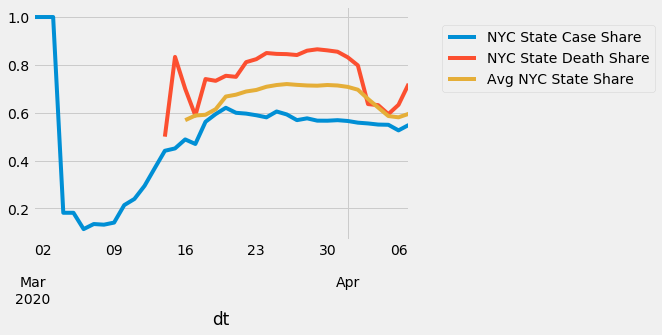

In [136]:
ax = df_reporting_fmt['NYC_case_share'].dropna().plot(label='NYC State Case Share', legend=True)
_ = df_reporting_fmt['NYC_death_share'].dropna().plot(label='NYC State Death Share', legend=True, ax=ax)
_ = df_reporting_fmt['NYC_mean_share'].dropna().rolling(3).mean().plot(
label='Avg NYC State Share', legend=True, ax=ax)
_ = plt.legend(loc='upper left', bbox_to_anchor=(1.07, 0.95), ncol=1)


## Bring in Movement Data from City Mapper

In [137]:
## THIS SECTION STOPPED WORKING ON APRIL 4 ##

In [138]:
# raw_entropy = pd.read_html('https://citymapper.com/cmi/nyc')

# l_cardinals = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th', '21st', '22nd', '23rd', '24th', '25th', '26th', '27th', '28th', '29th', '30th', '31st']

# df_entropy = raw_entropy[0].astype(str).applymap(lambda x: 
#                      x[3:] if x[:3] in l_cardinals else (x[4:] if x[:4] in l_cardinals else x))
# df_entropy = df_entropy.replace('%','', regex=True)
# df_entropy = df_entropy.apply(pd.to_numeric, errors='coerce')/100.
# df_entropy = df_entropy.dropna(how='all').reset_index()
# df_entropy = df_entropy.drop(columns='index')
# df_entropy.columns = list(range(2,9))
# df_entropy = df_entropy.stack().reset_index()
# df_entropy['day_o_month'] = (df_entropy['level_0'] * 7 + df_entropy['level_1']).astype(str)
# df_entropy['dt'] = pd.to_datetime('2020-03-'+df_entropy['day_o_month'])
# df_entropy = df_entropy[[0,'dt']]
# df_entropy = df_entropy.rename(columns={0:'entropy_pct'}).set_index('dt').sort_index()
# df_entropy.head()

## Bring in Google Data

In [139]:
df_goog = pd.read_pickle('./data/df_counties_20200329.pkl')
df_goog.head()


category                           grocery/pharmacy  parks  residential  \
state   county         date                                               
Alabama Autauga County 2020-02-16             0.795    NaN          NaN   
                       2020-02-17            -0.398    NaN          NaN   
                       2020-02-18             0.401    NaN          NaN   
                       2020-02-19            -0.402    NaN          NaN   
                       2020-02-20            -2.871    NaN          NaN   

category                           retail/recreation  transitstations  \
state   county         date                                             
Alabama Autauga County 2020-02-16              0.179              NaN   
                       2020-02-17              8.054              NaN   
                       2020-02-18             -1.745              NaN   
                       2020-02-19             -1.733              NaN   
                       2020-02-20             -8.061              NaN   

category                           workplace  
state   county         date                   
Alabama Autauga County 2020-02-16     -4.223  
                       2020-02-17    -28.153  
                       2020-02-18      1.890  
                       2020-02-19      1.868  
                       2020-02-20      1.248

In [140]:
df_goog.loc['New York'].unstack(0)['transitstations'].columns

Index(['Albany County', 'Allegany County', 'Bronx County', 'Broome County',
       'Chautauqua County', 'Chemung County', 'Chenango County',
       'Clinton County', 'Columbia County', 'Cortland County',
       'Delaware County', 'Dutchess County', 'Erie County', 'Essex County',
       'Franklin County', 'Fulton County', 'Genesee County', 'Greene County',
       'Herkimer County', 'Jefferson County', 'Livingston County',
       'Madison County', 'Monroe County', 'Montgomery County', 'Nassau County',
       'New York County', 'Niagara County', 'Oneida County', 'Onondaga County',
       'Ontario County', 'Orange County', 'Orleans County', 'Oswego County',
       'Otsego County', 'Rensselaer County', 'Richmond County',
       'Rockland County', 'Saratoga County', 'Schenectady County',
       'Schoharie County', 'St. Lawrence County', 'Steuben County',
       'Ulster County', 'Warren County', 'Westchester County',
       'Wyoming County', 'Yates County'],
      dtype='object', name='county

In [141]:
'New York County', 'Bronx County'

('New York County', 'Bronx County')

## Bring in State Data

In [144]:
df_st_testing_raw = pd.read_csv(
    'https://raw.githubusercontent.com/COVID19Tracking/covid-tracking-data/master/data/states_daily_4pm_et.csv')
df_st_testing = df_st_testing_raw
df_st_testing['dt'] = pd.to_datetime(df_st_testing['date'], format="%Y%m%d")
print("State Testing Data Last Observation: ", df_st_testing.date.max())
df_st_testing = df_st_testing.rename(columns={'state':'code'})
df_st_testing = df_st_testing.set_index(['code','dt']).sort_index()

df_st_testing.loc[['NY'],:] = (
    df_st_testing.loc[['NY'],:].shift(-1))
df_st_testing.loc[['NY']].tail()

State Testing Data Last Observation:  20200407


date  positive  negative  pending  \
code dt                                                    
NY   2020-04-03  20200404.0  113704.0  169917.0      NaN   
     2020-04-04  20200405.0  122031.0  180249.0      NaN   
     2020-04-05  20200406.0  130689.0  190122.0      NaN   
     2020-04-06  20200407.0  138863.0  201195.0      NaN   
     2020-04-07         NaN       NaN       NaN      NaN   

                 hospitalizedCurrently  hospitalizedCumulative  \
code dt                                                          
NY   2020-04-03                15905.0                 26383.0   
     2020-04-04                16479.0                 28092.0   
     2020-04-05                16837.0                 30203.0   
     2020-04-06                17493.0                 32083.0   
     2020-04-07                    NaN                     NaN   

                 inIcuCurrently  inIcuCumulative  onVentilatorCurrently  \
code dt                                                                   
NY   2020-04-03          4126.0              NaN                    NaN   
     2020-04-04          4376.0              NaN                    NaN   
     2020-04-05          4504.0              NaN                    NaN   
     2020-04-06          4593.0              NaN                    NaN   
     2020-04-07             NaN              NaN                    NaN   

                 onVentilatorCumulative  ...  hospitalized     total  \
code dt                                  ...                           
NY   2020-04-03                     NaN  ...       26383.0  283621.0   
     2020-04-04                     NaN  ...       28092.0  302280.0   
     2020-04-05                     NaN  ...       30203.0  320811.0   
     2020-04-06                     NaN  ...       32083.0  340058.0   
     2020-04-07                     NaN  ...           NaN       NaN   

                totalTestResults    posNeg  fips  deathIncrease  \
code dt                                                           
NY   2020-04-03         283621.0  283621.0  36.0          630.0   
     2020-04-04         302280.0  302280.0  36.0          594.0   
     2020-04-05         320811.0  320811.0  36.0          599.0   
     2020-04-06         340058.0  340058.0  36.0          731.0   
     2020-04-07              NaN       NaN   NaN            NaN   

                 hospitalizedIncrease  negativeIncrease  positiveIncrease  \
code dt                                                                     
NY   2020-04-03                2687.0           12260.0           10841.0   
     2020-04-04                1709.0           10332.0            8327.0   
     2020-04-05                2111.0            9873.0            8658.0   
     2020-04-06                1880.0           11073.0            8174.0   
     2020-04-07                   NaN               NaN               NaN   

                 totalTestResultsIncrease  
code dt                                    
NY   2020-04-03                   23101.0  
     2020-04-04                   18659.0  
     2020-04-05                   18531.0  
     2020-04-06                   19247.0  
     2020-04-07                       NaN  

[5 rows x 24 columns]

In [145]:
fillin_NYS_hosp = pd.Series(
    [240,379,656,830,1239,1337,2049,2520,3069.,4079.], index=
         pd.date_range('2020-03-15','2020-03-24'))

df_st_testing = df_st_testing.unstack(0)
df_st_testing.loc[:,[('hospitalizedCurrently','NY')]
                            ] = df_st_testing.loc[
    :,('hospitalizedCurrently','NY')].fillna(fillin_NYS_hosp)
df_st_testing = df_st_testing.stack().swaplevel().sort_index()


## Bring in NYC DOH Data

In [146]:
df_nycdoh_raw = pd.read_csv('https://github.com/nychealth/coronavirus-data/raw/master/case-hosp-death.csv')
df_nycdoh = df_nycdoh_raw
df_nycdoh['dt'] = pd.to_datetime(df_nycdoh['DATE_OF_INTEREST'])
df_nycdoh = df_nycdoh.set_index('dt')
df_nycdoh.tail()

DATE_OF_INTEREST  NEW_COVID_CASE_COUNT  HOSPITALIZED_CASE_COUNT  \
dt                                                                           
2020-04-03           4/3/20                  4173                   1137.0   
2020-04-04           4/4/20                  2730                    788.0   
2020-04-05           4/5/20                  2212                    302.0   
2020-04-06           4/6/20                  1587                     17.0   
2020-04-07           4/7/20                   101                      NaN   

            DEATH_COUNT  
dt                       
2020-04-03        285.0  
2020-04-04        272.0  
2020-04-05        290.0  
2020-04-06        199.0  
2020-04-07         22.0

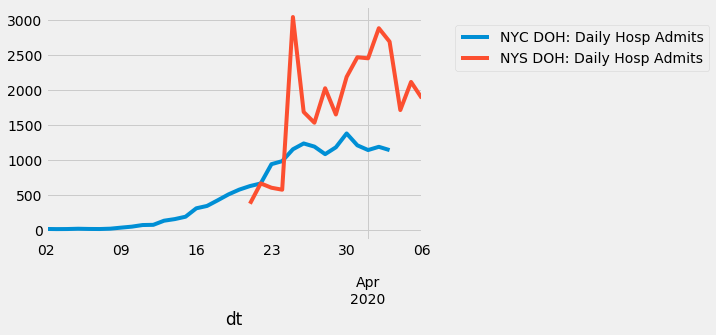

In [147]:
#Note: While all of the NYC DOH data is subject to change, the most recent three days are extremely
# volatile. So, we exclude those days.
ax = df_nycdoh.HOSPITALIZED_CASE_COUNT.iloc[:-4].plot(label='NYC DOH: Daily Hosp Admits')
df_st_testing.loc['NY']['hospitalizedCumulative'].diff().plot(ax=ax, label='NYS DOH: Daily Hosp Admits')
_ = plt.legend(loc='upper left', bbox_to_anchor=(1.07, 0.95), ncol=1)

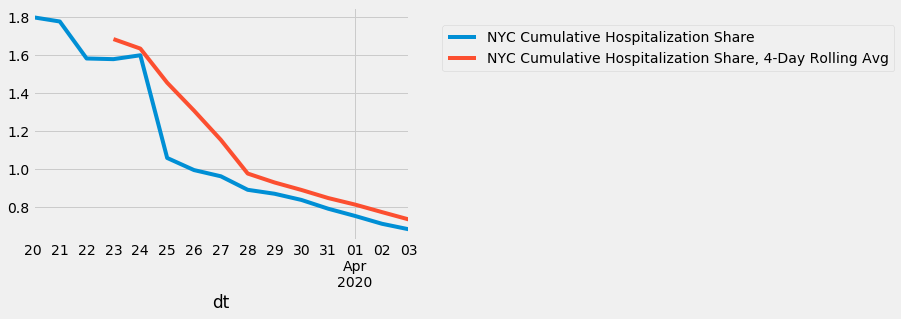

In [148]:
df_reporting_fmt['NYC_cumulhosp_share'] = (df_nycdoh['HOSPITALIZED_CASE_COUNT'].cumsum().iloc[:-4]/df_st_testing.loc['NY']['hospitalizedCumulative']
)
ax = df_reporting_fmt['NYC_cumulhosp_share'].dropna().plot(label='NYC Cumulative Hospitalization Share', legend=True)
df_reporting_fmt['NYC_cumulhosp_share'].rolling(4).mean().dropna().plot(
    label='NYC Cumulative Hospitalization Share, 4-Day Rolling Avg', legend=True, ax=ax)
_ = plt.legend(loc='upper left', bbox_to_anchor=(1.07, 0.95), ncol=1)


## Estimate NYC Simultaneous Hospitalization Data

In [149]:
df_st_testing.loc['NY',('hospitalizedCurrently')].tail()

dt
2020-04-02    14810.0
2020-04-03    15905.0
2020-04-04    16479.0
2020-04-05    16837.0
2020-04-06    17493.0
Name: hospitalizedCurrently, dtype: float64

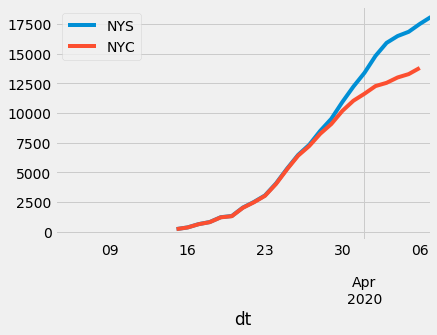

In [150]:
df_hosps = pd.DataFrame(df_st_testing.loc['NY',('hospitalizedCurrently')])
df_hosps.columns = ['NYS']
df_hosps.loc[pd.Timestamp('2020-04-07'),'NYS'] = 18079
df_hosps['NYC'] = df_reporting_fmt['NYC_cumulhosp_share'
                                  ].fillna(method='bfill').clip(upper=0.99).rolling(7).mean().fillna(method='ffill')\
.mul(df_st_testing.loc['NY',('hospitalizedCurrently')])
df_hosps.plot()

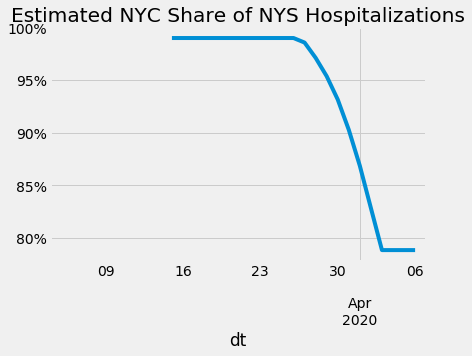

In [151]:
ax = df_hosps['NYC'].div(df_hosps.NYS).plot(title='Estimated NYC Share of NYS Hospitalizations')
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.0%}'))


# Model Functions

In [152]:
def seir_model(suspop_0, exposed_0, infectious_0, recovered_0, deaths_0, last_obs_dt, 
               r0, d_incub, d_infect, 
               t):

    suspop, exposed, infectious, resolved = [suspop_0], [exposed_0], [infectious_0], [recovered_0 + deaths_0]
    alpha = 1 / d_incub
    beta = r0 / d_infect
    gamma = 1 / d_infect
    totpop = suspop_0 + exposed_0 + infectious_0 + recovered_0 + deaths_0
    
    for t_ in t[:-1]:
        dS_dt = -1 * min(beta * suspop[-1] * infectious[-1] / totpop, suspop[-1]) 
        dE_dt = (dS_dt * -1) - (alpha * exposed[-1])
        dI_dt = (alpha * exposed[-1]) - (gamma * infectious[-1])
        dR_dt = (gamma * infectious[-1])
        
        next_suspop = suspop[-1] + dS_dt
        next_exposed = exposed[-1] + dE_dt
        next_infectious = infectious[-1] + dI_dt
        next_resolved = resolved[-1] + dR_dt
        
        suspop.append(next_suspop)
        exposed.append(next_exposed)
        infectious.append(next_infectious)
        resolved.append(next_resolved)
        
    df_out = pd.DataFrame(np.stack([suspop, exposed, infectious, resolved]).T,
                         index = pd.date_range(last_obs_dt, 
                                               last_obs_dt + pd.Timedelta(days=t.shape[0]-1)),
                         columns = ['suspop', 'exposed', 'infectious', 'resolved'])
        
    return df_out


In [153]:
def param_str_maker(d_incub, d_infect, d_to_hosp, d_in_hosp, d_til_death,
                    hosp_rt, icu_rt, vent_rt, mort_rt, basic_r0):
    
    param_dict = {'d_incub':(d_incub,'{:.1f}'), 
                  'd_infect':(d_infect,'{:.1f}'), 
                  'd_to_hosp':(d_to_hosp,'{:.1f}'), 
                  'd_in_hosp':(d_in_hosp,'{:.1f}'), 
                  'd_til_death':(d_til_death,'{:.1f}'),
                  'hosp_rt':(hosp_rt,'{:.2%}'), 
                  'icu_rt':(icu_rt,'{:.2%}'), 
                  'vent_rt':(vent_rt,'{:.2%}'), 
                  'mort_rt':(mort_rt,'{:.2%}'), 
                  'basic_r0':(basic_r0,'{:.1f}')}
    param_fmtd_dict = {}

    for param_name, param_tup in param_dict.items():
        param_val, param_fmt = param_tup
        if type(param_val) == tuple:
            param_fmtd_dict[param_name] = (param_fmt+' - '+param_fmt).format(*param_val)
        else:
            param_fmtd_dict[param_name] = param_fmt.format(param_val)
        

    param_str = '\n'.join(('Parameters Used',
                           r'$D_{{incubation}}: {}$'.format(param_fmtd_dict['d_incub'], ),
                           r'$D_{{infectious}}: {}$'.format(param_fmtd_dict['d_infect'], ),
                           r'$D_{{to hospital}}: {}$'.format(param_fmtd_dict['d_to_hosp'], ),
                           r'$D_{{in hospital}}: {}$'.format(param_fmtd_dict['d_in_hosp'], ),
                           r'$D_{{til death}}: {}$'.format(param_fmtd_dict['d_til_death'], ),
                           r'$Rate_{{Hospitalization}}: {}$'.format(param_fmtd_dict['hosp_rt'], )+'%',
                           r'$Rate_{{ICU}}: {}$'.format(param_fmtd_dict['icu_rt'], )+'%',
                           r'$Rate_{{Ventilator}}: {}$'.format(param_fmtd_dict['vent_rt'], )+'%',
                           r'$Rate_{{Mortality}}: {}$'.format(param_fmtd_dict['mort_rt'], )+'%',
                           r'$Basic R_{{0}}: {}$'.format(param_fmtd_dict['basic_r0'], )
                          ))
    return param_str

In [154]:
def ch_exposed_infectious(df_agg, r_t, region_name, param_str, chart_title=""):
    plt.style.use('fivethirtyeight')
    df_chart = df_agg[['exposed','infectious']]
#     df_chart = df_chart.iloc[8:]

    ax = df_chart.plot.area(figsize=[14,8], title=chart_title, legend=True,
                           color=['#e5ae38','#fc4f30'])
    _ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    plt.legend(['Exposed Population','Infectious Population'],
               loc='upper left', bbox_to_anchor=(1.07, 0.95), ncol=1)
    ax2 = ax.twinx()
    r_t[:df_chart.index[-1]].plot(ax=ax2, color='black', linewidth=2, linestyle='--', 
                       label='Reproduction Factor (r0) - Right Axis', legend=True)
    plt.legend(loc="lower right")
    ax.set_ylim([0, ax.axes.get_yticks().max()])
    ax.set_yticks(np.linspace(0,ax.axes.get_yticks().max(),5))
    ax2.set_ylim([0, ax2.axes.get_yticks().max()])
    ax2.set_yticks(np.linspace(0,ax2.axes.get_yticks().max(),5))
    ax.text(1.08, 0.05, param_str, transform=ax.transAxes,
        verticalalignment='bottom', bbox={'ec':'black','lw':1})
    plt.show()

In [155]:
def ch_cumul_infections(df_agg, df_reporting_fmt, region_name, param_str, chart_title=""):
    plt.style.use('fivethirtyeight')
    df_chart = df_agg[['exposed', 'infectious', 'recovered', 'hospitalized', 'deaths']].sum(axis=1)
    df_chart = df_chart.iloc[8:]
    
    ax = df_chart.plot(figsize=[14,8], title=chart_title, legend=True, 
                       label='Forecast Cumulative Infections')
    _ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    if region_name in df_reporting_fmt['cases'].columns:
        df_reporting_fmt['cases'][region_name].loc['2020-03-01':].plot(
            ax=ax, linestyle=':', legend=True, color=['#008fd5'],
        label='Reported Cumulative Infections')
    plt.legend(loc='upper left', bbox_to_anchor=(1.07, 0.95), ncol=1)
    ax.text(1.08, 0.05, param_str, transform=ax.transAxes,
        verticalalignment='bottom', bbox={'ec':'black','lw':1})
    plt.show()
    

In [179]:
def ch_hosp(df_agg, df_hosps, df_reporting_fmt, region_name, param_str, chart_title=""):
    df_chart = df_agg[['hospitalized','icu','vent','deaths']]
    df_chart = df_chart.iloc[8:]
    
    ax = df_chart.plot(figsize=[14,8], title=chart_title)
    _ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    if region_name in df_hosps.columns:
        df_hosps[region_name].plot(ax=ax, linestyle=':', legend=True,
                                   label='Observed {} Hospitalizations'.format(region_name))
    if region_name in df_reporting_fmt['deaths'].columns:
        df_reporting_fmt['deaths'][region_name].loc[
            df_hosps.index[0]:].plot(ax=ax, linestyle='-.', legend=True,
                                   label='deaths {} Cumulative Cases'.format(region_name))
    plt.legend(loc='upper left', bbox_to_anchor=(1.07, 0.95), ncol=1)
    ax.text(1.08, 0.05, param_str, transform=ax.transAxes,
        verticalalignment='bottom', bbox={'ec':'black','lw':1})
    plt.show()

In [157]:
def ch_population_share(df_agg, df_hosps, df_reporting_fmt, region_name, param_str, chart_title=""):
    df_chart = df_agg[['susceptible','deaths','exposed','hospitalized','infectious','recovered']]
    df_chart = df_chart.iloc[8:]
    
    ax = df_chart.plot.area(
        figsize=[14,8], title=chart_title)
    _ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.legend(loc='upper left', bbox_to_anchor=(1.07, 0.95), ncol=1)
    ax.text(1.08, 0.05, param_str, transform=ax.transAxes,
        verticalalignment='bottom', bbox={'ec':'black','lw':1})
    plt.show()
    

In [158]:
def ch_doubling_rt(df_agg, df_hosps, df_reporting_fmt, region_name, param_str, chart_title=""):
    ## DOUBLING RATE CHART
    df_chart = np.log(2)/df_agg[['hospitalized','deaths']].pct_change()
#     df_chart = df_chart.loc[hosp_obs_dt:]
    df_chart = df_chart.iloc[8:]
    
    ax = df_chart.plot(figsize=[14,8], title='Forecast Doubling Rate: '+chart_title,
                      color=['#008fd5','#e5ae38'])
    if region_name in df_hosps.columns:
        hosp_dr = np.log(2)/df_hosps[region_name].pct_change().rolling(3).mean()
        hosp_dr.plot(ax=ax, linestyle=':', legend=True, color=['#008fd5'],
                     label='Observed {} Hospitalizations'.format(region_name))
    if region_name in df_reporting_fmt['deaths'].columns:
        deaths_dr = np.log(2)/df_reporting_fmt['deaths'][region_name].pct_change().rolling(3)\
            .mean().loc[hosp_dr.index[0]:]
        deaths_dr.plot(ax=ax, linestyle='-.', legend=True, color=['#e5ae38'],
                       label='Deaths {} Cumulative Cases'.format(region_name))
    plt.yscale('log')
    _ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1f}'))
    plt.legend(loc='upper left', bbox_to_anchor=(1.07, 0.95), ncol=1)
    ax.text(1.08, 0.05, param_str, transform=ax.transAxes,
        verticalalignment='bottom', bbox={'ec':'black','lw':1})
    plt.show()
    

In [159]:
def daily_cohort_model(cohort_strt, d_to_fore, 
                       d_incub, d_infect,
                       mort_rt, d_in_hosp, hosp_rt, d_til_death, d_in_hosp_mild, d_to_hosp,
                       icu_rt, d_in_icu, vent_rt,
                       E_0, I_0=0., H_0=0., ICU_0=0., R_0=0., D_0=0.
                      ):
    
    t = np.linspace(0, int(d_to_fore)-1, int(d_to_fore))

    E = [E_0]
    I = [I_0]
    H = [H_0]
    ICU = [ICU_0]
    R = [R_0]
    D = [D_0]
    
    for t_ in t[:-1]:
        
        #### PROBABILITY DISTRIBUTIONS FOR FLOWS ####
        prob_dI_t = gamma.pdf(t_,d_incub)

        prob_mild_dR_t = (1 - hosp_rt) * gamma.pdf(t_, d_infect+d_incub)

        prob_H_inflow_t = hosp_rt * gamma.pdf(t_, d_to_hosp+d_incub)


        prob_sev_dR_t = (hosp_rt - mort_rt) * gamma.pdf(t_, (d_in_hosp+d_to_hosp)/2, scale=2, 
                                            loc=d_incub)

        prob_dD_t = mort_rt * gamma.pdf(t_, d_til_death/2, scale=2, loc=d_incub)
        #############################################
        

        ############## FLOW ACCOUNTING ##############
        # Change in Exposed Population
        dE = -1 * min(prob_dI_t * E_0, E[-1])
        
        # Hospital Outflows, limited to be no more than hospital capacity
        d_hosp_outflow = -1 * min((prob_sev_dR_t * (E_0+I_0) 
                                   + H_0 * (prob_sev_dR_t / (hosp_rt - mort_rt)) * (1-mort_rt/hosp_rt))
                                + (prob_dD_t * (E_0+I_0) 
                                   + H_0 * (prob_dD_t / mort_rt) * mort_rt/hosp_rt ), 
                                  H[-1])
        
        if (prob_sev_dR_t + prob_dD_t) > 0:
            # Severe Recoveries - Component of Hospital Outflows
            d_sevR = (-1 * prob_sev_dR_t * d_hosp_outflow) / (prob_sev_dR_t + prob_dD_t)

            # Deaths - Component of Hospital Outflows
            dD = (-1 * prob_dD_t * d_hosp_outflow) / (prob_sev_dR_t + prob_dD_t)
        else:
            # Severe Recoveries - Component of Hospital Outflows
            d_sevR = 0.
            # Deaths - Component of Hospital Outflows
            dD = 0.
        
        # New Hospital Admittances
        d_hosp_admits = ((prob_H_inflow_t * (E_0+I_0)))
#                          + (hosp_rt * I_0 * ((1-1/d_to_hosp)**(t_-1) - (1-1/d_to_hosp)**t_)))
        
        # Infectious Inflows
        dI_inflow = -1 * dE
        
        # Mild Recoveries
        d_mildR = min(prob_mild_dR_t * (E_0+I_0), I[-1] + dI_inflow - d_hosp_admits)
        
        # Change in Recovered Population
        dR = d_mildR + d_sevR
        
        # Change in Hospitalized Population
        dH = d_hosp_admits + d_hosp_outflow
        
        # Infectious Outflows
        dI_outflow = d_mildR + d_hosp_admits
        
        # Net change in Infectious Population
        dI = dI_inflow - dI_outflow
        
        if round(dI_inflow - dI_outflow) < round(-1 * I[-1]):
            print('dI_inflow',dI_inflow)
            print('dI_outflow',dI_outflow)
            print('round(dI_inflow - dI_outflow)',round(dI_inflow - dI_outflow))
            print('I[-1]',I[-1])
            raise Exception(cohort_strt, 'Daily Cohort Infectious Net Outflows are greater than Infectious Population') 
        #############################################

        E.append(E[-1] + dE)
        I.append(I[-1] + dI)
        R.append(R[-1] + dR)
        H.append(H[-1] + dH)
        D.append(D[-1] + dD)
    df_out = pd.DataFrame(np.stack([E, I, R, H, D]).T, 
                          columns = ['exposed', 'infectious', 'recovered', 'hospitalized', 'deaths'],
                          index = pd.date_range(cohort_strt, 
                                                cohort_strt + pd.Timedelta(days=d_to_fore-1)))
    df_out['icu'] = df_out['hospitalized'].mul(icu_rt)
    df_out['vent'] = df_out['hospitalized'].mul(icu_rt*vent_rt)
    df_out.index = pd.DatetimeIndex(df_out.index).normalize()
    df_out.index.name = 'dt'
    df_out.columns.name = 'metric'
    
    return df_out


In [160]:
def seir_model_cohort(suspop_0, exposed_0, infectious_0, hospitalized_0, recovered_0, deaths_0, 
                      hosp_obs_dt, r_t, d_incub, d_infect, d_to_forecast, 
                      mort_rt, d_in_hosp, hosp_rt, d_til_death, d_in_hosp_mild, d_to_hosp,
                      icu_rt, d_in_icu, vent_rt
                     ):

    d_to_forecast = int(d_to_forecast)
    int_displace = int(d_incub+d_to_hosp)
    suspop = [suspop_0]
    next_infectious  = infectious_0
    _gamma = 1 / d_infect
    totpop = suspop_0 + exposed_0 + infectious_0 + hospitalized_0 + recovered_0 + deaths_0
    
    t = np.linspace(0, d_to_forecast+int_displace, 
                    d_to_forecast+int_displace+1)
    
    df_all_cohorts = pd.DataFrame()
    df_all_cohorts.columns.name = 'cohort_dt'
    last_r = r_t[0]
    
    for t_ in t[:-1]:
        this_r = r_t[int(t_)]
        
        beta = this_r * _gamma
        cohort_strt = hosp_obs_dt + pd.Timedelta(days=t_-int_displace)
        d_to_fore = t[-1] - t_ + 1
        
        if this_r != last_r:
            last_r = this_r

        if t_ == 0:
            dS = 0
            
            df_daily_cohort = daily_cohort_model(
                cohort_strt, d_to_fore, 
                d_incub, d_infect, mort_rt, d_in_hosp, 
                hosp_rt, d_til_death, d_in_hosp_mild, d_to_hosp,
                icu_rt, d_in_icu, vent_rt,
                E_0=exposed_0, I_0=infectious_0, H_0=hospitalized_0, 
                ICU_0=0., 
                R_0=recovered_0, D_0=deaths_0
            )

            df_all_cohorts[cohort_strt] = df_daily_cohort.stack()
            
            df_daily_cohort_scalar = daily_cohort_model(
                cohort_strt, d_to_fore, 
                d_incub, d_infect, mort_rt, d_in_hosp, 
                hosp_rt, d_til_death, d_in_hosp_mild, d_to_hosp,
                icu_rt, d_in_icu, vent_rt,
                1e6
            ).reset_index(drop=True)
            
        else:
            dS = -1 * min(beta * suspop[-1] * next_infectious / totpop, suspop[-1]) 
            
            df_daily_cohort = dS * -1 * df_daily_cohort_scalar.iloc[:int(d_to_fore)] / 1e6
            
            df_daily_cohort.index = pd.date_range(cohort_strt, 
                                                  cohort_strt + pd.Timedelta(days=d_to_fore - 1))
            df_all_cohorts[cohort_strt] = df_daily_cohort.stack()
    
        d_cohort_totpop_std = round(df_daily_cohort[
            ['exposed','deaths','hospitalized','infectious','recovered']
        ].dropna().sum(axis=1).std(),3)
        
        if d_cohort_totpop_std != 0.0:
            print(cohort_strt, d_cohort_totpop_std)
            display(df_daily_cohort)
            raise Exception('Daily Cohort total population varies significantly') 
        
        df_agg = df_all_cohorts.sum(axis=1).unstack()
        df_agg.index = pd.DatetimeIndex(df_agg.index).normalize()
        next_infectious = df_agg.loc[cohort_strt,'infectious']
        next_suspop = suspop[-1] + dS
        suspop.append(next_suspop)
        
        totpopchk = df_agg.loc[cohort_strt, ['exposed','infectious','recovered','hospitalized','deaths']].sum()
        
        if (round(totpopchk + suspop[-1]) != round(totpop)):
            display(df_all_cohorts.sum(axis=1).unstack())
            print(cohort_strt)
            print('totpop: ', round(totpop))
            print(suspop_0, exposed_0, infectious_0, recovered_0, deaths_0)
            print('dS ', dS)
            print('sum of df_agg', totpopchk)
            print('suspop[-1]', suspop[-1])
            print('sum of both', round(totpopchk+suspop[-1]))
            raise Exception('Agg total population varies significantly') 

    ## Adjust initiailized cohort hospitalizations to observation. ##
#     hosp_acts_rat = curr_hosp/df_all_cohorts.sum(axis=1).unstack(1)['hospitalized'].loc[hosp_obs_dt]
#     df_new_hosp = df_all_cohorts.loc[:,:hosp_obs_dt].unstack(1).swaplevel(axis=1)[
#         ['hospitalized','icu','vent']]*hosp_acts_rat
#     df_new_hosp = df_new_hosp.stack(0)
#     df_all_cohorts.update(df_new_hosp)
    #################################################################
    
    df_agg = df_all_cohorts.sum(axis=1).unstack()
    df_agg.index = pd.DatetimeIndex(df_agg.index).normalize()

    s_suspop = pd.Series(suspop, index = pd.date_range(
        hosp_obs_dt - pd.Timedelta(days=int_displace+1), 
        hosp_obs_dt + pd.Timedelta(days=d_to_forecast-1)))
        
    df_agg['susceptible'] = pd.Series(s_suspop)
    
    return df_agg.dropna(), df_all_cohorts

In [161]:
def run_cohort_model(d_to_forecast, curr_suspop, curr_hosp, exposed_pct, curr_recovered, curr_deaths,
                     hosp_obs_dt, basic_r0, r_dates,
                     d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt,
                     d_til_death, d_in_hosp_mild, d_to_hosp,
                     icu_rt, d_in_icu, vent_rt,
                     scenario_name, region_name, df_hosps, df_reporting_fmt
                    ):
    
    curr_exposed = curr_hosp/hosp_rt*exposed_pct
    curr_infectious = curr_hosp/hosp_rt*(1-exposed_pct)
    
    H_series = pd.Series(np.nan, index=pd.date_range(hosp_obs_dt - pd.Timedelta(days=int(d_incub+d_to_hosp)), 
                                                     periods = 45))
    H_series = H_series.fillna(df_hosps[region_name]).fillna(0.)
    H_0 = H_series[hosp_obs_dt - pd.Timedelta(days=int(d_incub+d_to_hosp))]
    
    ## These dates don't affect the curve at all. They just make sure we have enough time series for the R ##
    r_t = pd.Series(np.nan, index=pd.date_range(hosp_obs_dt - pd.Timedelta(days=int(d_incub+d_to_hosp+10)), 
                                                hosp_obs_dt + pd.Timedelta(days=d_to_forecast+100)))
    pa_s = pd.DataFrame(r_dates)
    pa_s = pa_s.set_index(pa_s.columns[0])[pa_s.columns[1]]
    pa_s.index = pd.to_datetime(pa_s.index).normalize()
    r_t.index = pd.DatetimeIndex(r_t.index).normalize()
    r_t = r_t.fillna(pa_s)
    if pd.isnull(r_t.iloc[0]):
        r_t.iloc[0] = basic_r0
    r_t = r_t.fillna(method='ffill')
    l_r_t = r_t.to_list()
    
    chart_title = "{0}: {1} Scenario - Basic R0: {2:.2f}\nForecast Using Hospitalization Data through {3}".format(
        region_name, scenario_name, basic_r0, hosp_obs_dt.strftime("%d %b"))

    df_agg, df_all_cohorts = seir_model_cohort(
        curr_suspop, curr_exposed, curr_infectious, H_0,
        curr_recovered, curr_deaths, hosp_obs_dt,
        l_r_t, d_incub, d_infect, d_to_forecast, mort_rt, d_in_hosp, 
        hosp_rt, d_til_death, d_in_hosp_mild, d_to_hosp,
        icu_rt, d_in_icu, vent_rt
    ) 
    
    df_agg['r_t'] = r_t
    
    param_str = param_str_maker(d_incub, d_infect, d_to_hosp, d_in_hosp, d_til_death,
                    hosp_rt, icu_rt, vent_rt, mort_rt, basic_r0)
    ch_exposed_infectious(df_agg, r_t, region_name, param_str, chart_title)
    
    ch_hosp(df_agg, df_hosps, df_reporting_fmt, region_name, param_str, chart_title)
    
    ch_cumul_infections(df_agg, df_reporting_fmt, region_name, param_str, chart_title)
    
    ch_population_share(df_agg, df_hosps, df_reporting_fmt, region_name, param_str, chart_title)    

    ch_doubling_rt(df_agg, df_hosps, df_reporting_fmt, region_name, param_str, chart_title)
    
    print('Peak Hospitalization Date: ', df_agg.hospitalized.idxmax().strftime("%d %b, %Y"))
    print('Peak Hospitalization #: {:.0f}'.format(df_agg.hospitalized.max()))
    print('Peak ICU #: {:.0f}'.format(df_agg.icu.max()))
    print('Peak Ventilator #: {:.0f}'.format(df_agg.vent.max()))
    
    return df_agg, df_all_cohorts


In [162]:
def regr_repro(s_hosps, obs_dt, lookback, d_infect):
    y = s_hosps.loc[:obs_dt].iloc[-lookback:].dropna().values
    y = np.log(y)
    
    available_lookback = y.shape[0]
    X = np.linspace(0, available_lookback-1, available_lookback).reshape(-1, 1)
    reg = LinearRegression(fit_intercept=True).fit(X, y)

    _lambda = reg.coef_[0]
    _gamma = 1 / d_infect
    _beta = _lambda + _gamma
    _r0 = _beta / _gamma
    return _lambda, _gamma, _beta, _r0

def est_r_t(hosp_series, lookback, d_infect, offset_days):
    r_t = pd.Series(dtype='float64')
    for dt in hosp_series.dropna().iloc[2:].index:
        _,_,_,r_t.loc[dt] = regr_repro(hosp_series, dt, lookback, d_infect)
    r_t.index = (r_t.index - pd.Timedelta(days=(offset_days))).normalize()
    return r_t*1.1



# Model Parameters

In [176]:
############# MODEL PARAMETERS #################
# Total Population
total_pop = 19.6e6 #19.6e6 #8e6 

# Name of Region
region_name = "NYS"

hosp_obs_dt = pd.Timestamp('2020-03-26')#pd.Timestamp('2020-03-25')

# Current Hospitalizations
curr_hosp = df_hosps[region_name].loc[hosp_obs_dt]

# Proportion of Total Infected/Exposed Population that is Exposed (i.e. not yet infectious)
exposed_pct = .6 #.2

# Total # of cases currently recovered/immune
curr_recovered = 100e3

# Number of days to forecast
d_to_forecast = 134

# Days from exposure until symptoms (i.e. incubation period)
d_incub=4 #4

# Days after incubation period when infectious
d_infect=6.

# Mortality Rate
mort_rt=.017

# Average number of days in hospital for a hospitalized case
d_in_hosp=10.

# Hospitalization Rate of all infected people
hosp_rt=.05

# Days from end of incubation period until death for patients who die
d_til_death=11

# Days from incubation period til arrival in hospital for all hospitalizations
d_to_hosp=5. #11. #3. #7.

# ICU rate as a proportion of all hospitalizations.
icu_rt = 13./41. #Lancet Study Estimate
 
# Ventilator rate as a proportion of all hospitalizations
vent_rt = .7

# [Currently not functional] Days in hospital for mild hospitalizations
d_in_hosp_mild= 11. #NEJM Study Estimate

# [Currently not functional] Days in hospital for ICU hospitalizations
d_in_icu = 13. #NEJM Study Estimate

# 8 Days Before Hospitalization Data, 
# last_obs_dt = (hosp_obs_dt - pd.Timedelta(days=((d_incub+d_to_hosp)*1.))).round(freq='d')
# print('implied last obs dt:', last_obs_dt)

# Total # of deaths
curr_deaths = df_reporting_fmt['deaths'][region_name].loc[
    (hosp_obs_dt - pd.Timedelta(days=(d_incub+d_to_hosp))).normalize()]

# Susceptible Population
curr_suspop = total_pop - curr_hosp/hosp_rt - curr_recovered - curr_deaths
print('curr hosp obs dt: ', hosp_obs_dt)
print('curr_hosp: ',curr_hosp)
print('curr_deaths: ',curr_deaths)

curr hosp obs dt:  2020-03-26 00:00:00
curr_hosp:  6481.0
curr_deaths:  17.0


# Scenarios

In [177]:
df_scenarios = pd.DataFrame()

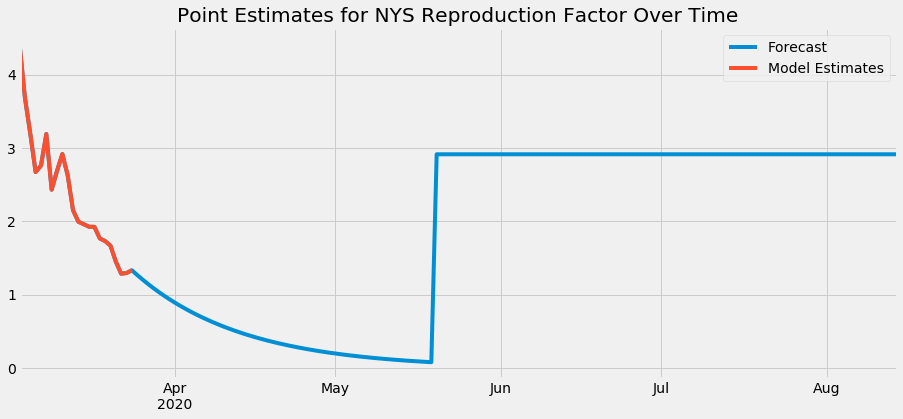

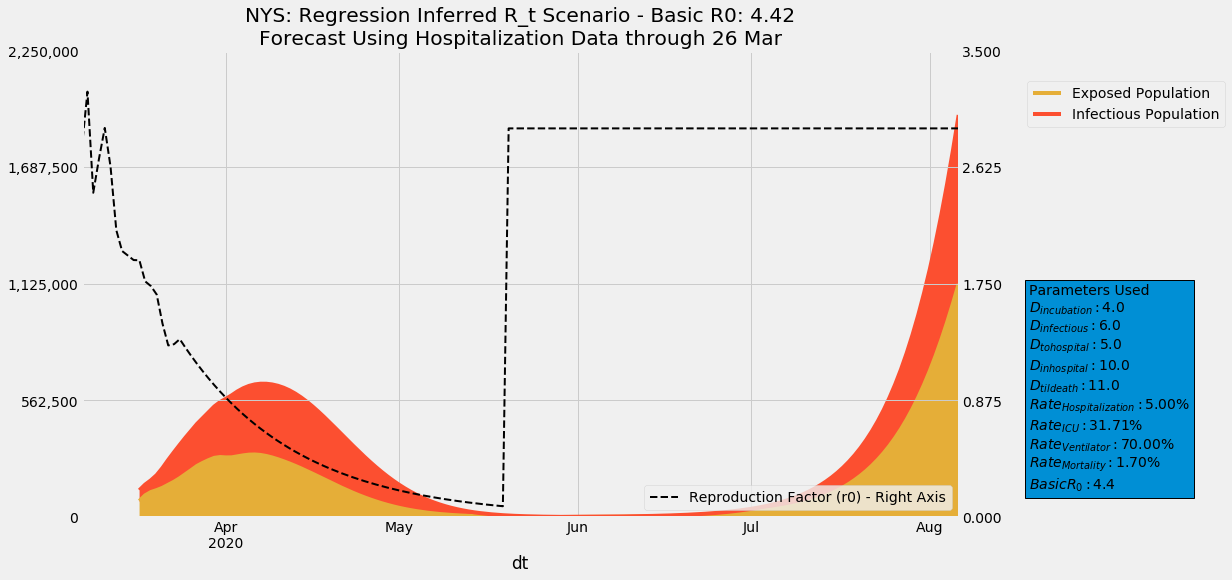

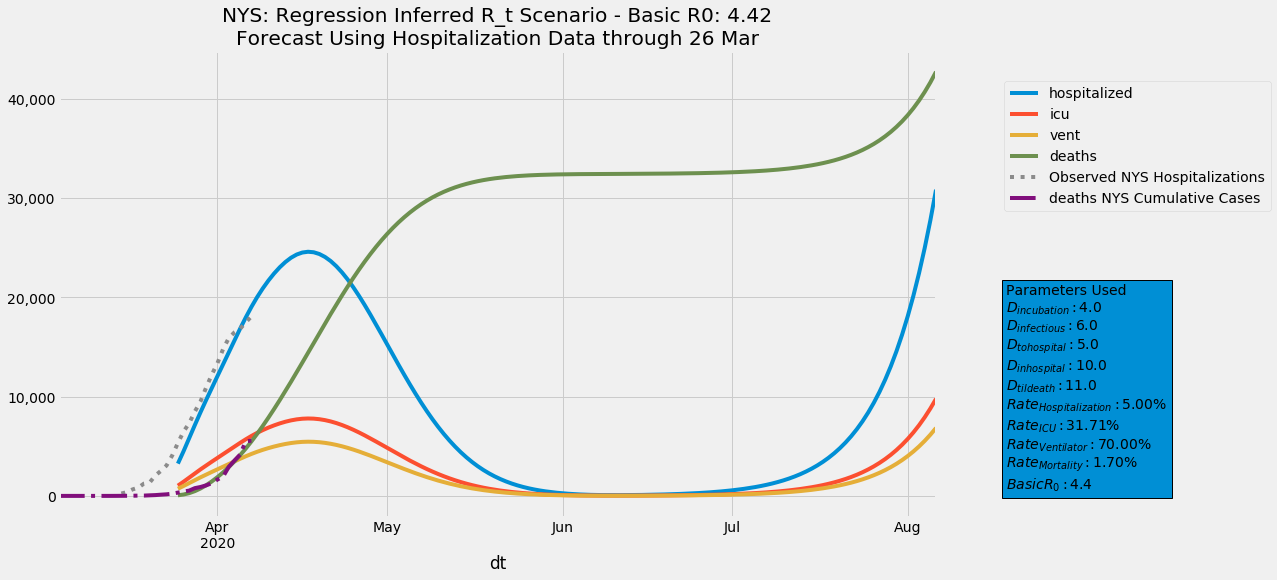

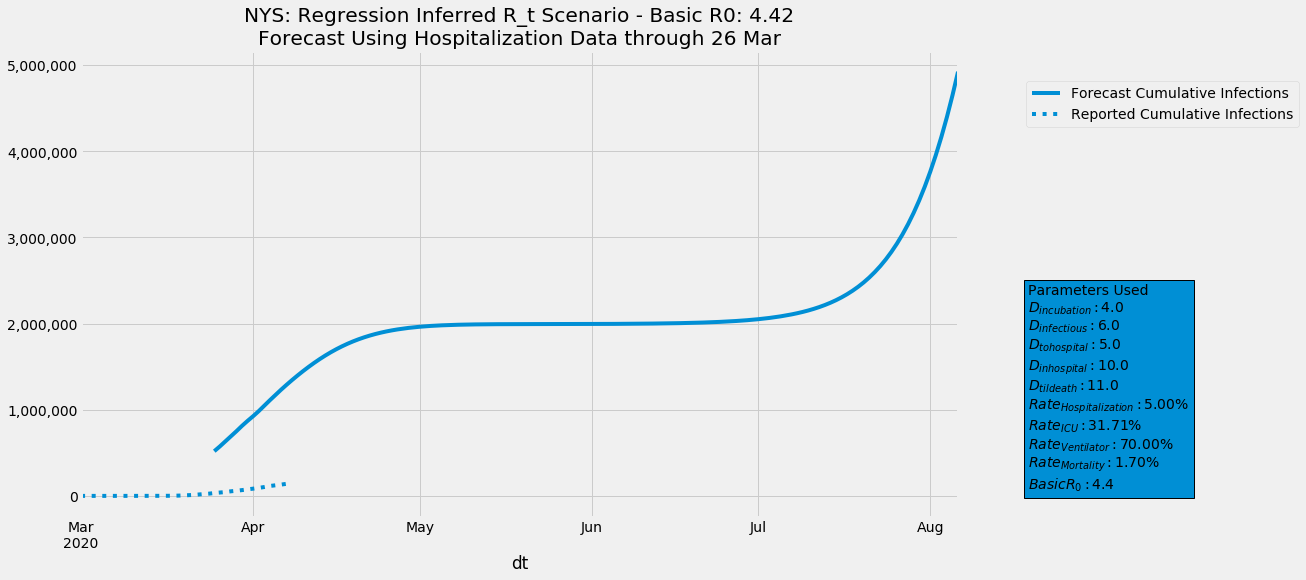

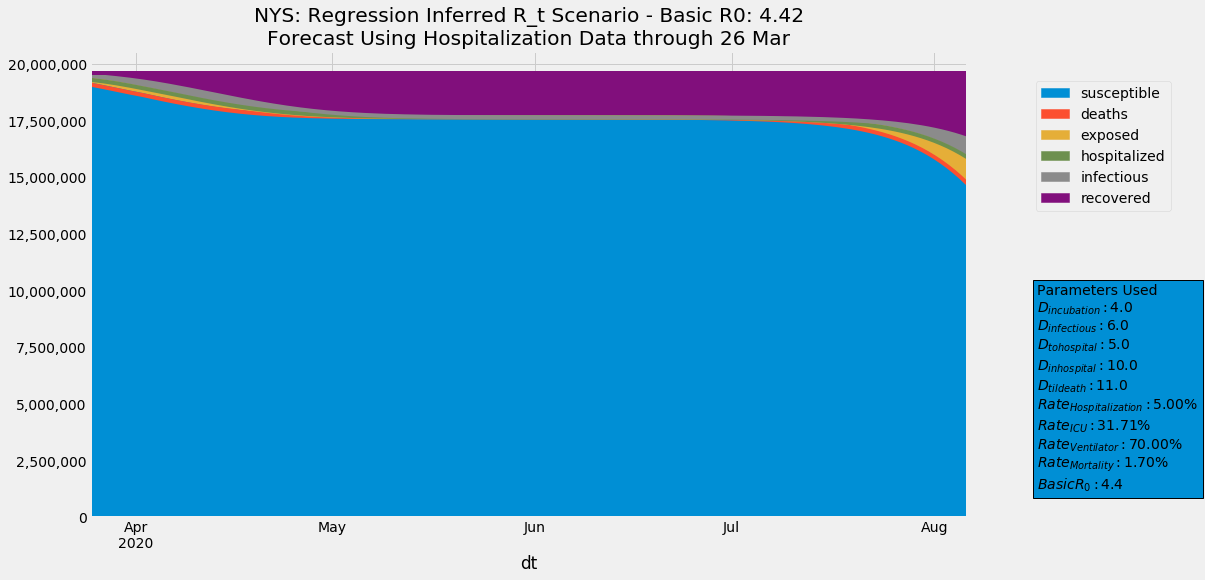

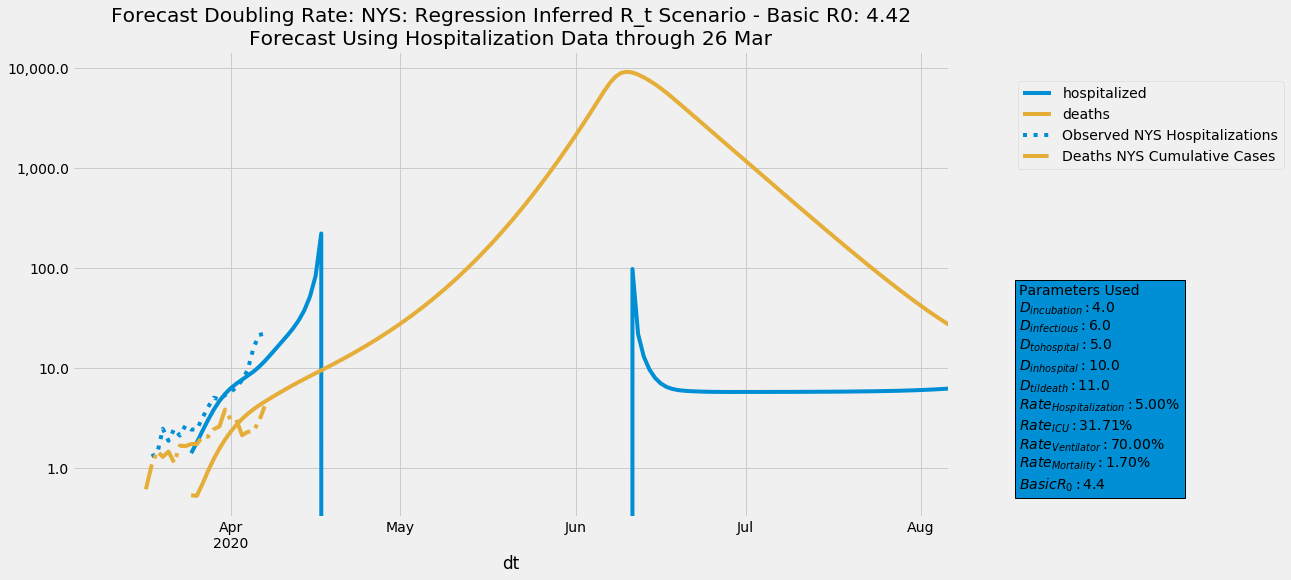

Peak Hospitalization Date:  06 Aug, 2020
Peak Hospitalization #: 30849
Peak ICU #: 9781
Peak Ventilator #: 6847


In [180]:
r_t = est_r_t(df_hosps[region_name], 3, d_infect, d_incub + d_to_hosp+5)
basic_r0 = r_t.iloc[0]

mul_r_t = pd.Series((1+r_t.pct_change().rolling(5).mean().iloc[-1]), 
                    index=pd.date_range(r_t.index[-1]+pd.Timedelta(days=1),
                                    r_t.index[-1]+pd.Timedelta(days=d_to_forecast+d_incub+d_to_hosp)
                                   )).cumprod()
fore_r_t = mul_r_t.mul(r_t.iloc[-1])
fore_r_t = pd.concat([r_t, fore_r_t])
fore_r_t.loc['2020-05-20':] = fore_r_t.iloc[0]*.66

ax = fore_r_t.plot(label='Forecast', figsize=[14,6], legend=True,
              title='Point Estimates for {} Reproduction Factor Over Time'.format(region_name))
r_t.plot(ax=ax, label='Model Estimates', legend=True)

r_dates = list(pd.DataFrame(fore_r_t).itertuples(index=True))
# Scenario Name
scenario_name = "Regression Inferred R_t"

df_agg, df_all_cohorts = run_cohort_model(
    d_to_forecast, curr_suspop, curr_hosp, exposed_pct, curr_recovered, curr_deaths, 
                 hosp_obs_dt, basic_r0, r_dates, 
                 d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt, 
                 d_til_death, d_in_hosp_mild, d_to_hosp, 
                 icu_rt, d_in_icu, vent_rt,
                 scenario_name, region_name, df_hosps, df_reporting_fmt)
df_scenarios[scenario_name] = df_agg.stack()

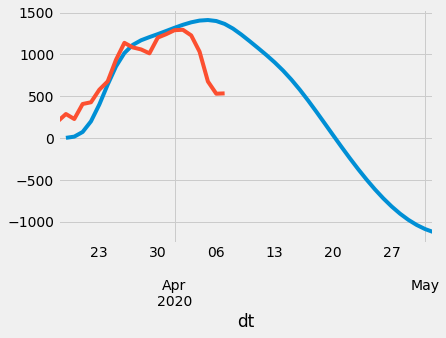

In [166]:
df_agg.hospitalized.diff().rolling(3).mean().dropna().iloc[:45].plot()
df_hosps[region_name].diff().rolling(3).mean().dropna().iloc[:45].plot()

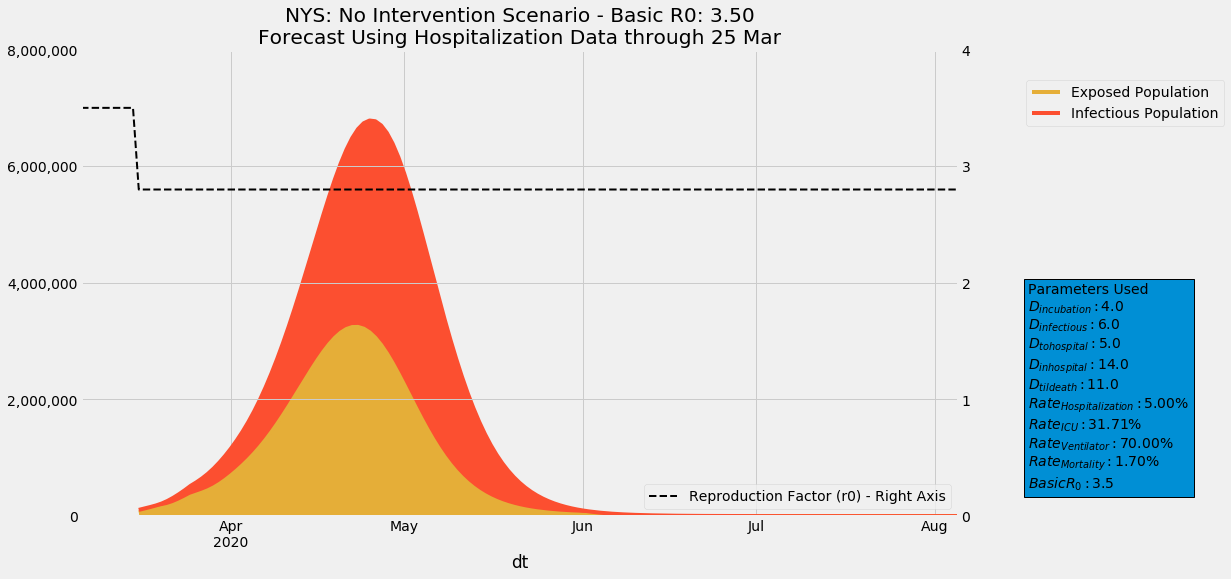

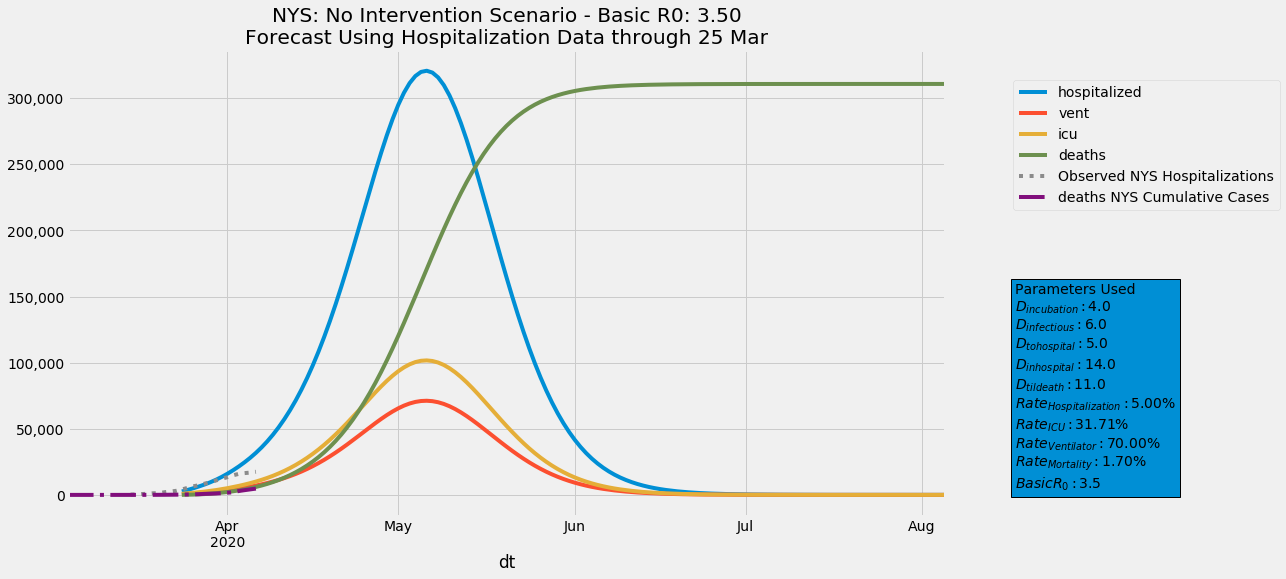

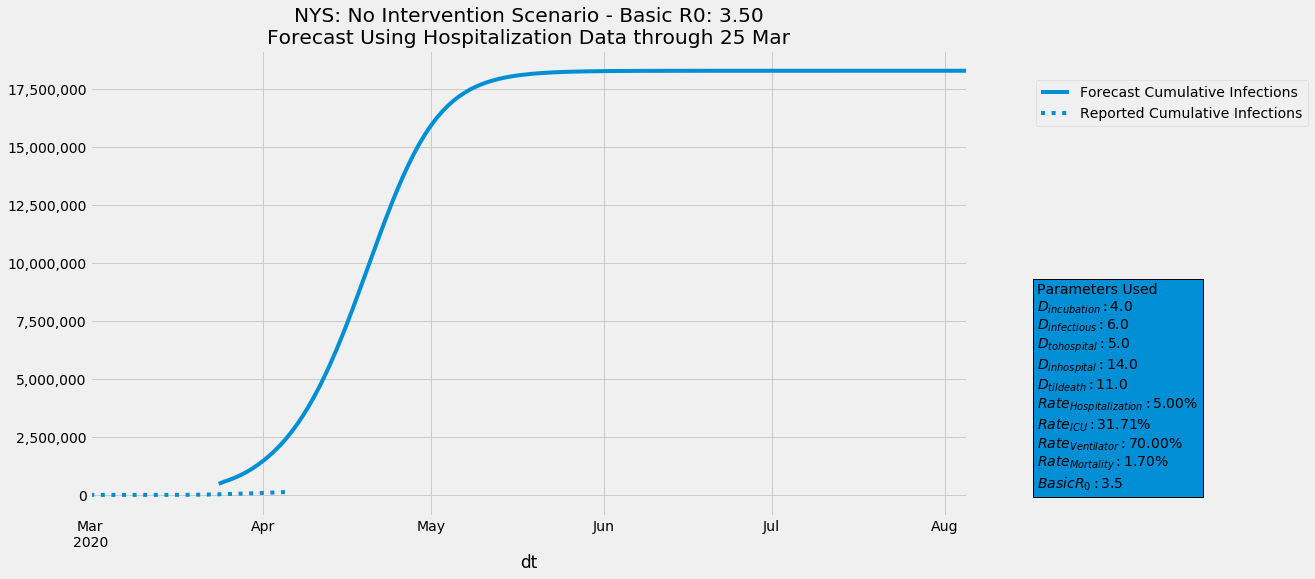

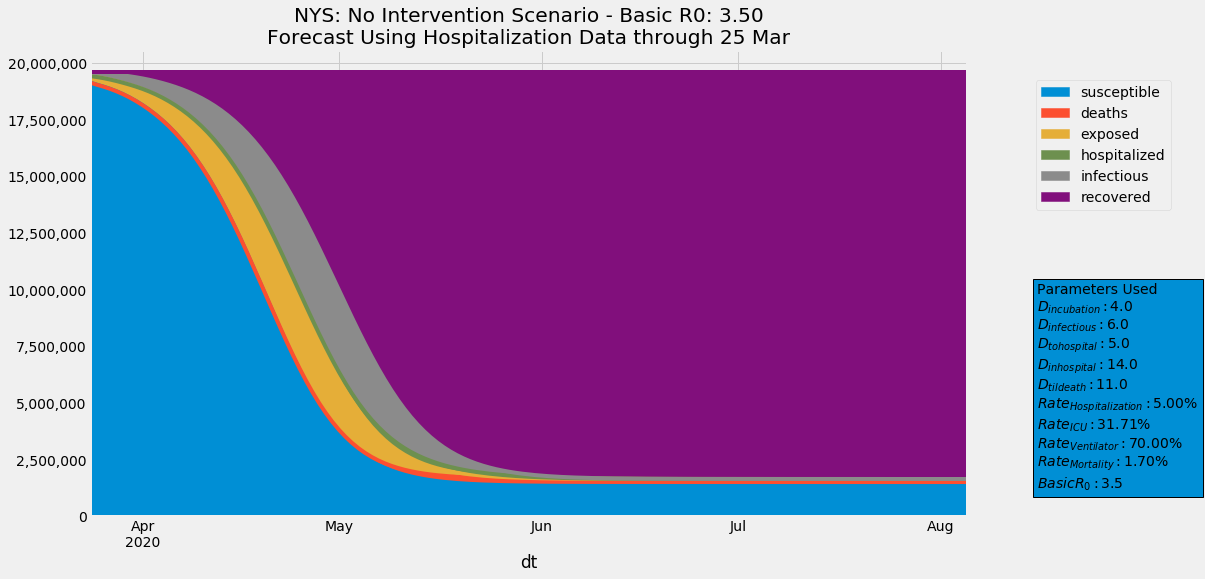

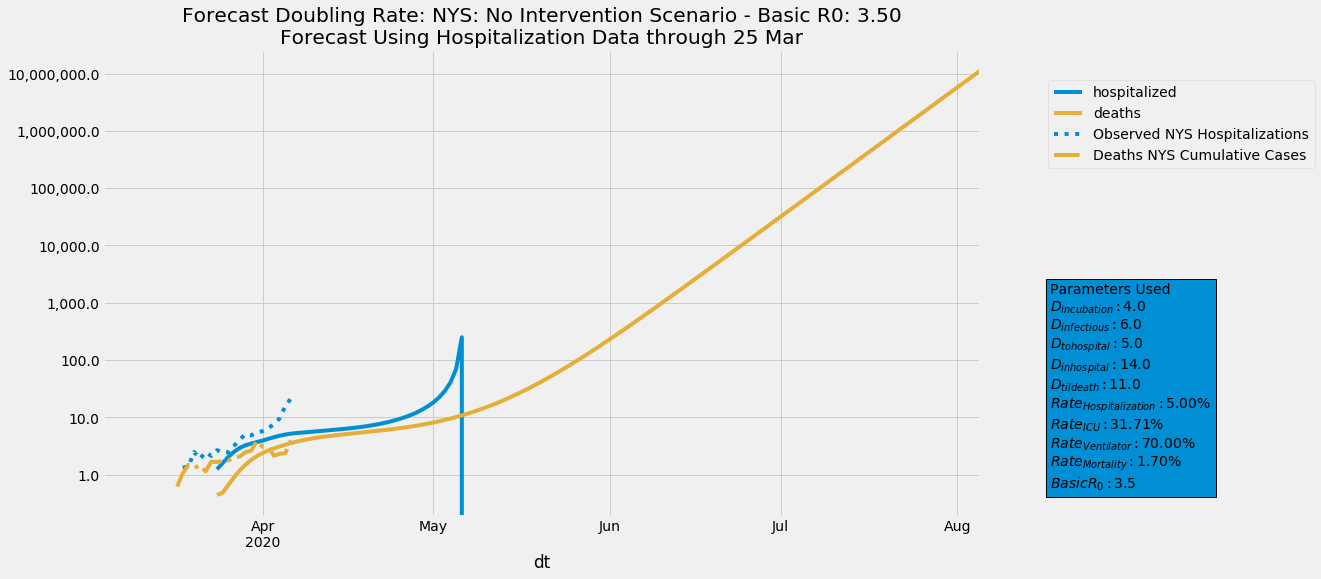

Peak Hospitalization Date:  06 May, 2020
Peak Hospitalization #: 320739
Peak ICU #: 101698
Peak Ventilator #: 71188


In [82]:
# Pre-intervention R0
basic_r0 = 3.5

# Scenario R0's. Within parentheses the first element should be the date when a policy starts. 
# The second element is the r0 value for that policy action. Policy actions should be separated by
# a comma.
r_dates = [('2020-03-16', basic_r0*.8)]

# Scenario Name
scenario_name = "No Intervention"

df_agg, df_all_cohorts = run_cohort_model(
    d_to_forecast, curr_suspop, curr_hosp, exposed_pct, curr_recovered, curr_deaths, 
                 hosp_obs_dt, basic_r0, r_dates, 
                 d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt, 
                 d_til_death, d_in_hosp_mild, d_to_hosp, 
                 icu_rt, d_in_icu, vent_rt,
                 scenario_name, region_name, df_hosps, df_reporting_fmt)
df_scenarios[scenario_name] = df_agg.stack()


In [83]:
# # Pre-intervention R0
# basic_r0 = 3.8
# entropy_rep_factor = 0.8
# entropy_lag_factor = int(d_incub+d_infect+2)

# adj_df_entropy = df_entropy.diff().mul(entropy_rep_factor).cumsum().add(
#     df_entropy.iloc[0]).fillna(df_entropy.iloc[0])
# adj_df_entropy = adj_df_entropy.reindex(
#     pd.date_range(adj_df_entropy.index[0],
#                   adj_df_entropy.index[-1]+pd.Timedelta(days=entropy_lag_factor) ) )
# adj_df_entropy = adj_df_entropy.shift(entropy_lag_factor).fillna(method='bfill').clip(lower=0.01)
# ax = adj_df_entropy['entropy_pct'].plot(label='adjusted movement', legend=True)
# df_entropy['entropy_pct'].plot(ax = ax, label='movement', legend=True)
# _ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
# plt.show()

# # Scenario R0's. Within parentheses the first element should be the date when a policy starts. 
# # The second element is the r0 value for that policy action. Policy actions should be separated by
# # a comma.
# r_dates = list(adj_df_entropy.mul(basic_r0).itertuples(index=True))

# # Scenario Name
# scenario_name = "Citymapper Data Adjusted Reproduction Factor"

# df_agg, df_all_cohorts = run_cohort_model(
#     d_to_forecast, curr_suspop, curr_hosp, exposed_pct, curr_recovered, curr_deaths, 
#                  hosp_obs_dt, basic_r0, r_dates, 
#                  d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt, 
#                  d_til_death, d_in_hosp_mild, d_to_hosp, 
#                  icu_rt, d_in_icu, vent_rt,
#                  scenario_name, region_name, df_hosps, df_reporting_fmt)
# df_scenarios[scenario_name] = df_agg.stack()


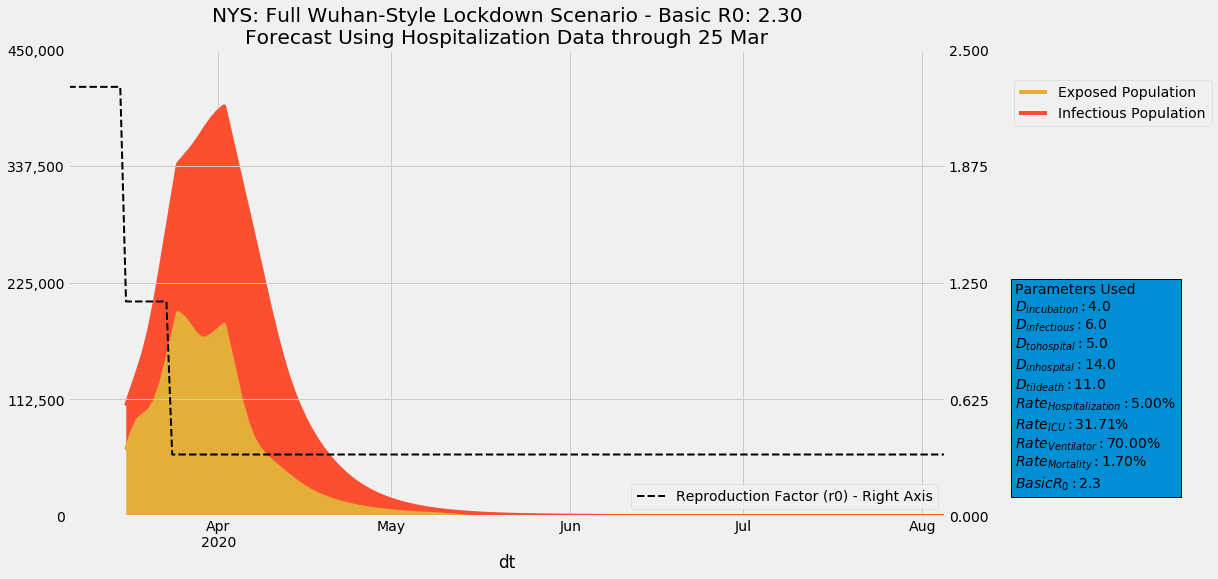

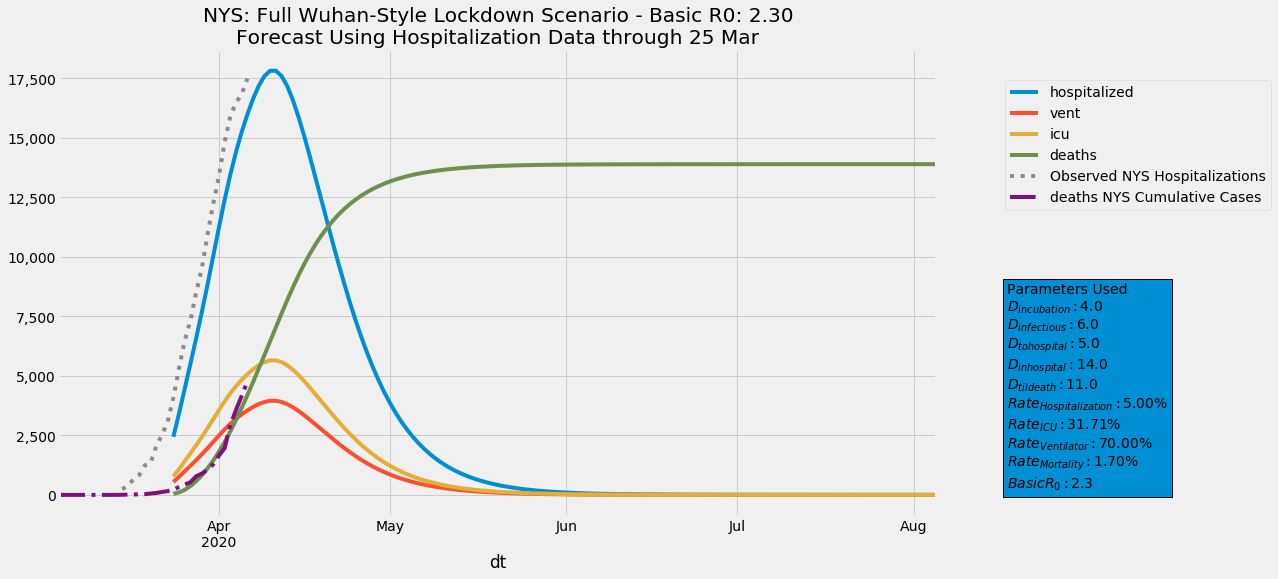

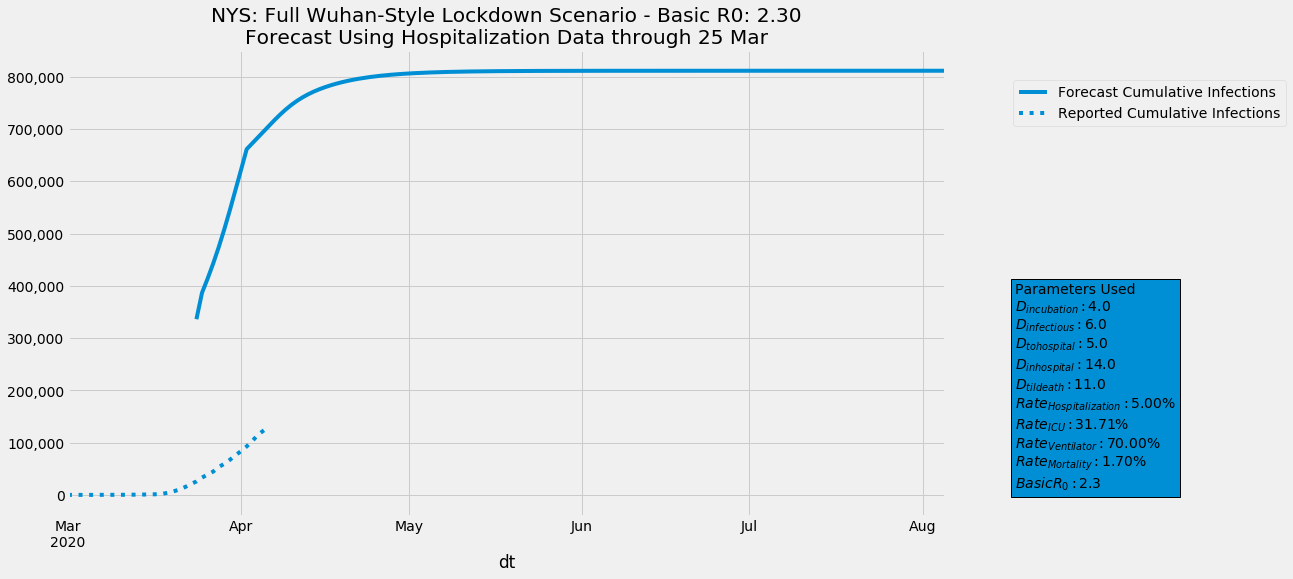

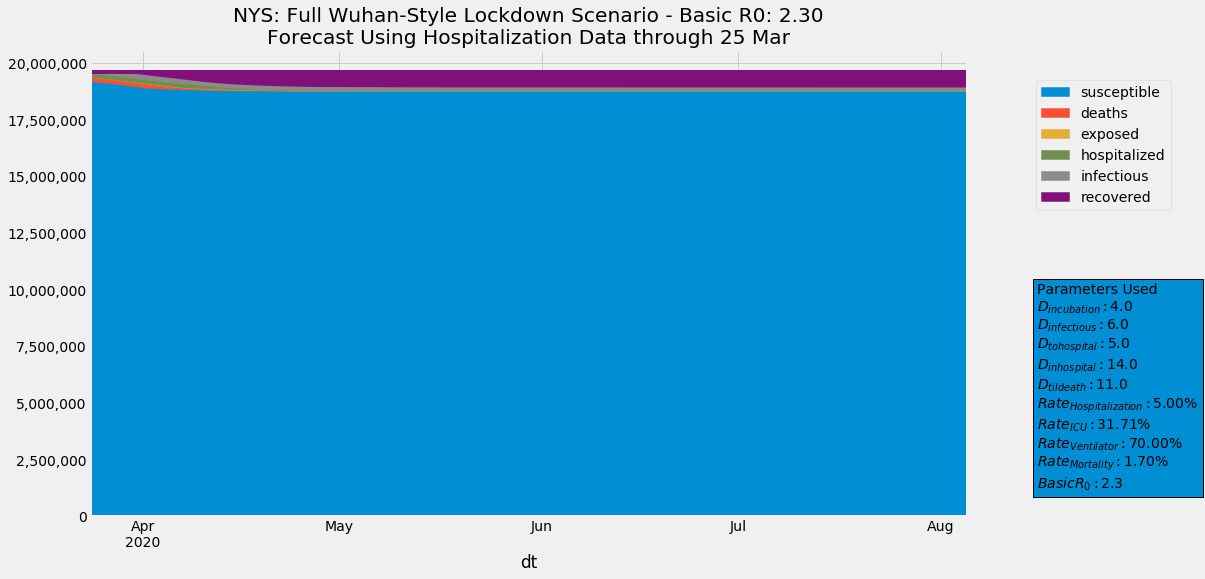

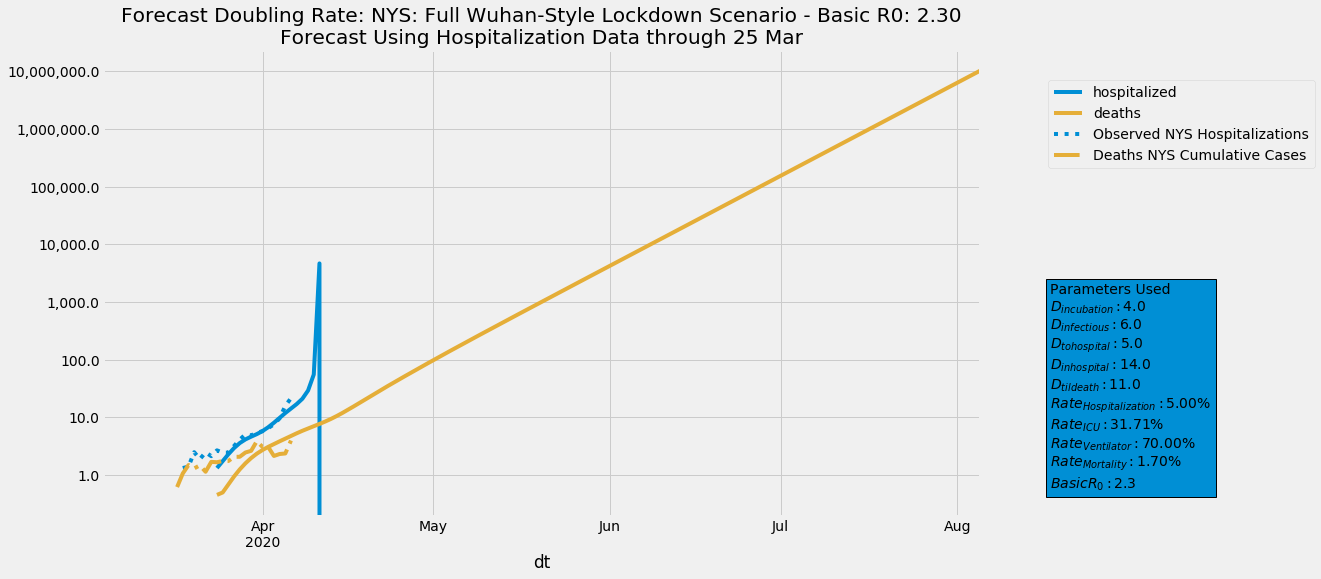

Peak Hospitalization Date:  11 Apr, 2020
Peak Hospitalization #: 17821
Peak ICU #: 5650
Peak Ventilator #: 3955


In [114]:
# Pre-intervention R0
basic_r0 = 2.3

# Scenario R0's. Within parentheses the first element should be the date when a policy starts. 
# The second element is the r0 value for that policy action. Policy actions should be separated by
# a comma.
r_dates = [('2020-03-16', basic_r0*.5), ('2020-03-24', 0.33), ('2021-05-15',basic_r0*.75)]

# Scenario Name
scenario_name = "Full Wuhan-Style Lockdown"

df_agg, df_all_cohorts = run_cohort_model(
    d_to_forecast, curr_suspop, curr_hosp, exposed_pct, curr_recovered, curr_deaths, 
                 hosp_obs_dt, basic_r0, r_dates, 
                 d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt, 
                 d_til_death, d_in_hosp_mild, d_to_hosp, 
                 icu_rt, d_in_icu, vent_rt,
                 scenario_name, region_name, df_hosps, df_reporting_fmt)
df_scenarios[scenario_name] = df_agg.stack()


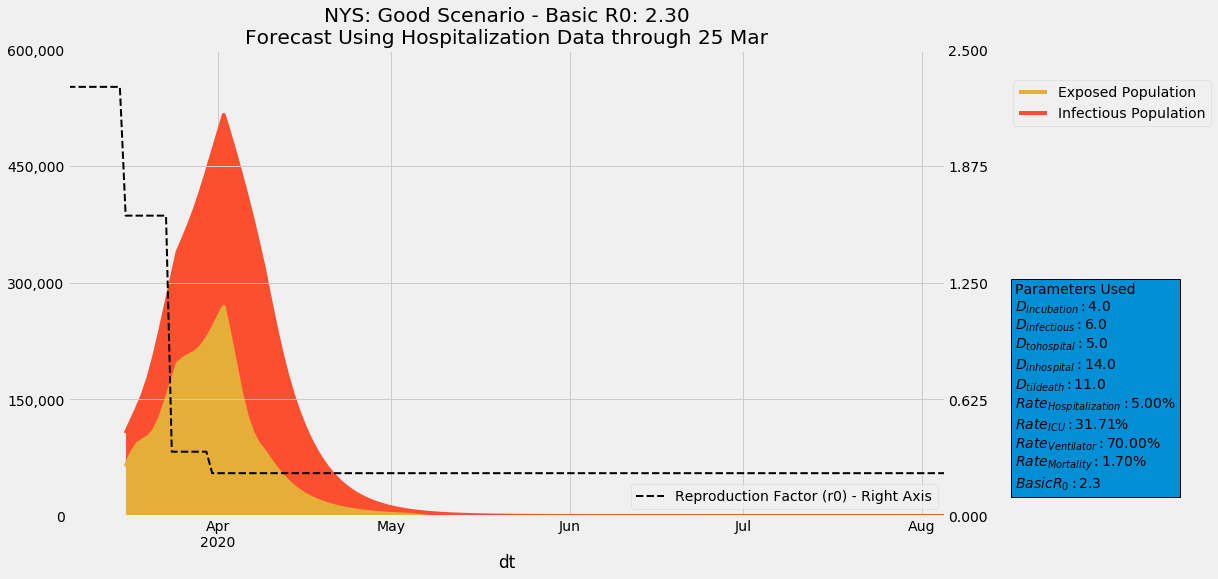

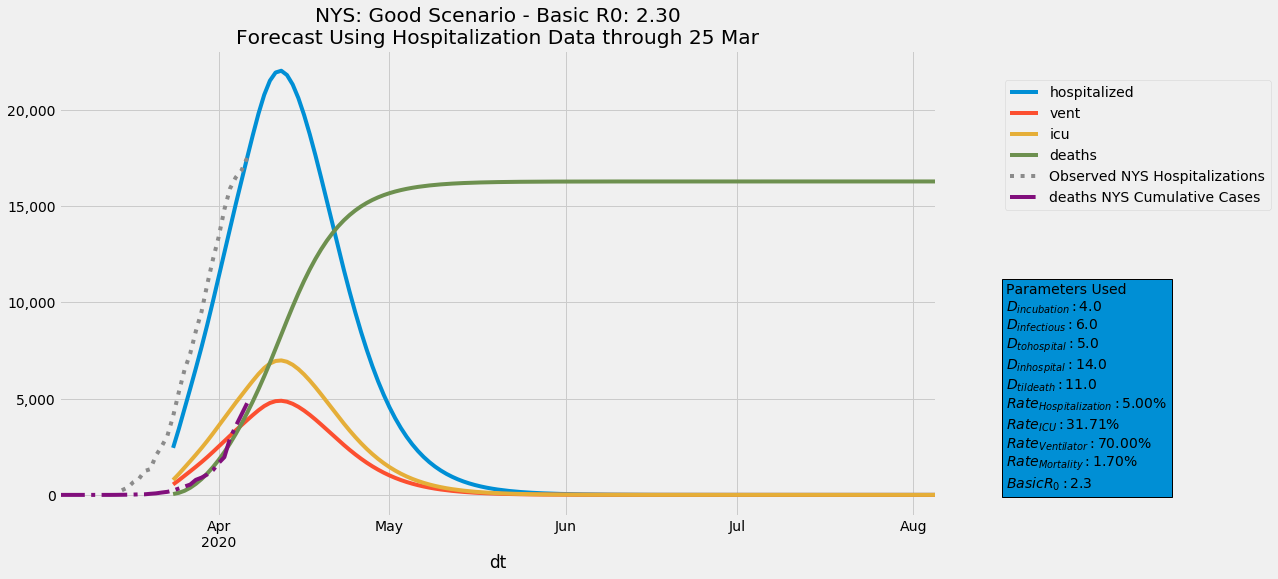

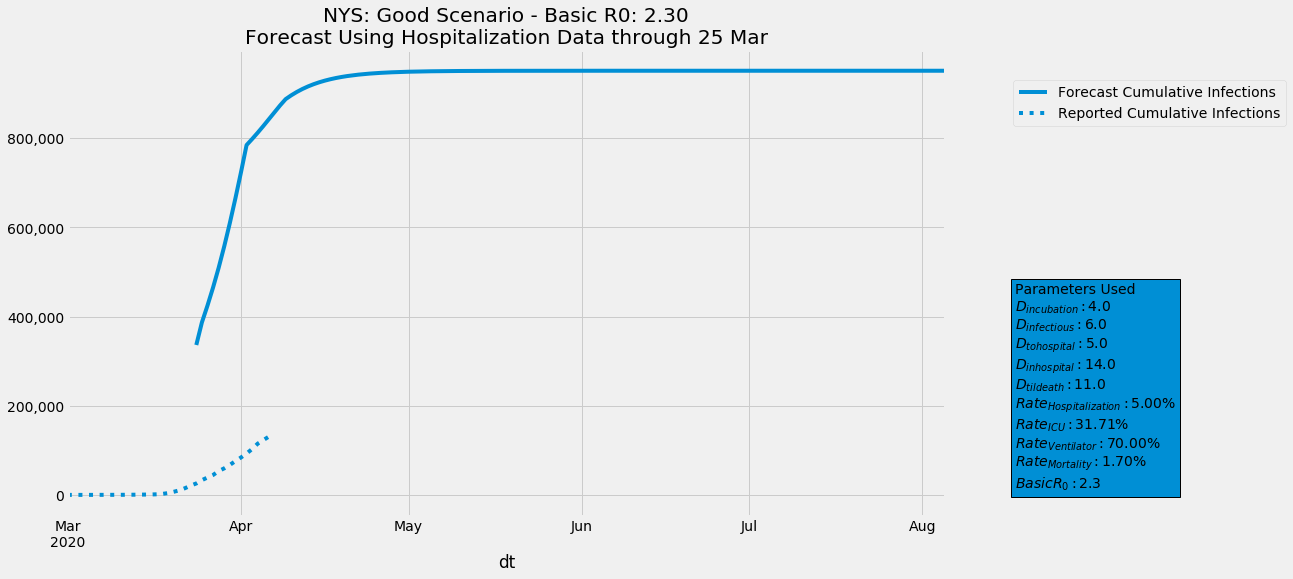

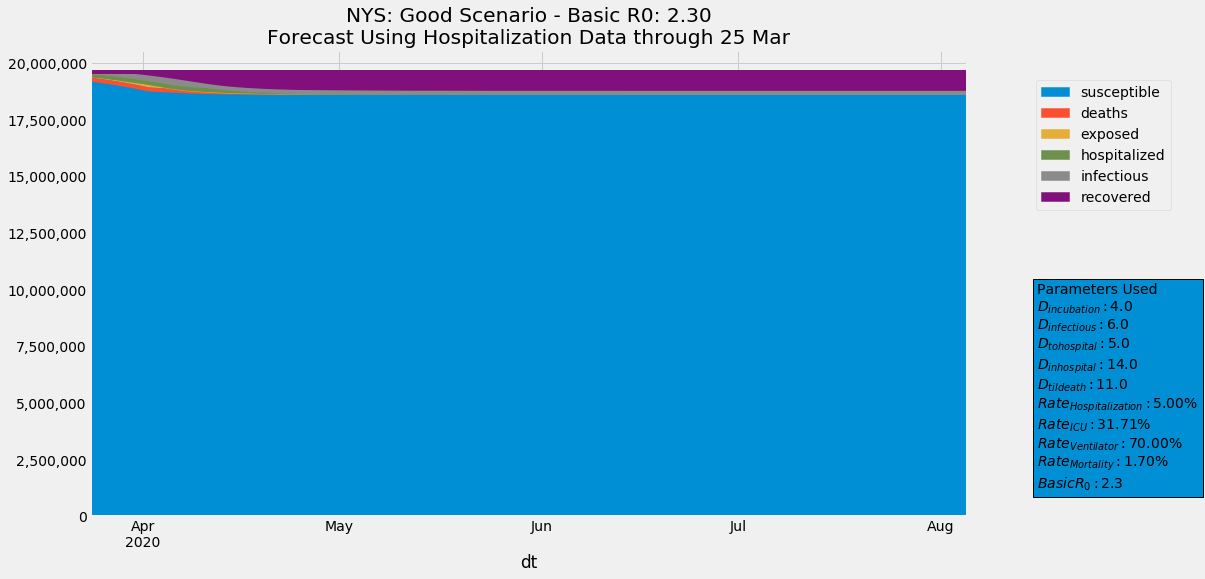

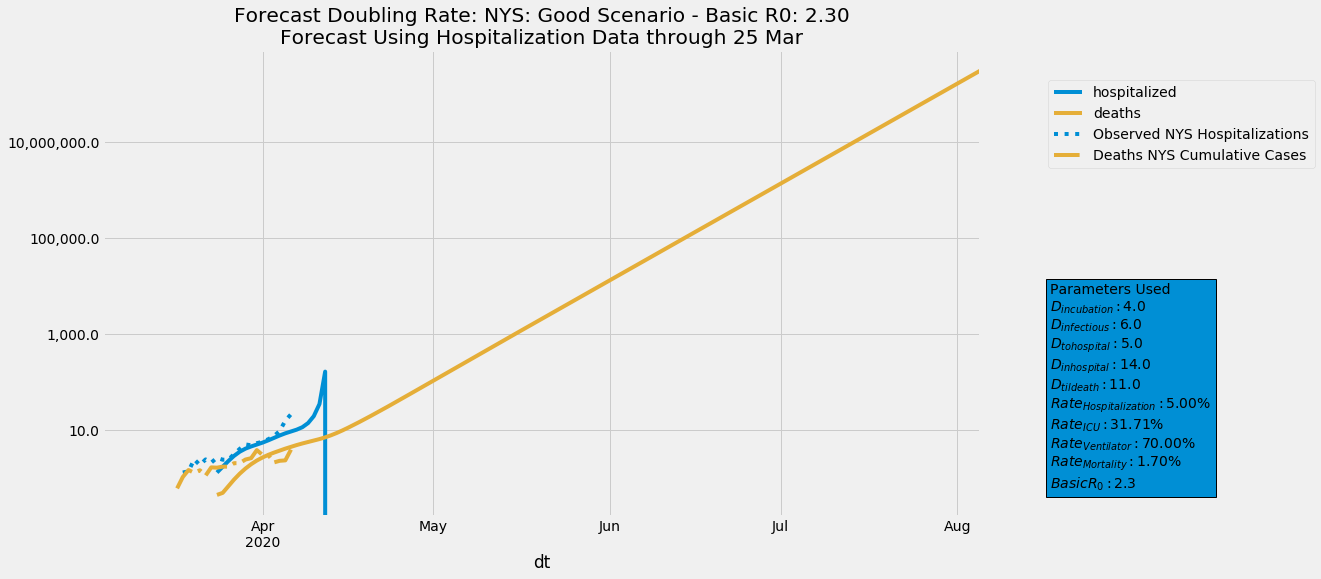

Peak Hospitalization Date:  12 Apr, 2020
Peak Hospitalization #: 22016
Peak ICU #: 6981
Peak Ventilator #: 4887


In [103]:
# Pre-intervention R0
basic_r0 = 2.3

# Scenario R0's. Within parentheses the first element should be the date when a policy starts. 
# The second element is the r0 value for that policy action. Policy actions should be separated by
# a comma.
r_dates = [('2020-03-16', basic_r0*.7), ('2020-03-24', basic_r0*.15), 
           ('2020-03-31',basic_r0*.1), ('2021-05-15', basic_r0*.6)]

# Scenario Name
scenario_name = "Good"

df_agg, df_all_cohorts = run_cohort_model(
    d_to_forecast, curr_suspop, curr_hosp, exposed_pct, curr_recovered, curr_deaths, 
                 hosp_obs_dt, basic_r0, r_dates, 
                 d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt, 
                 d_til_death, d_in_hosp_mild, d_to_hosp, 
                 icu_rt, d_in_icu, vent_rt,
                 scenario_name, region_name, df_hosps, df_reporting_fmt)
df_scenarios[scenario_name] = df_agg.stack()


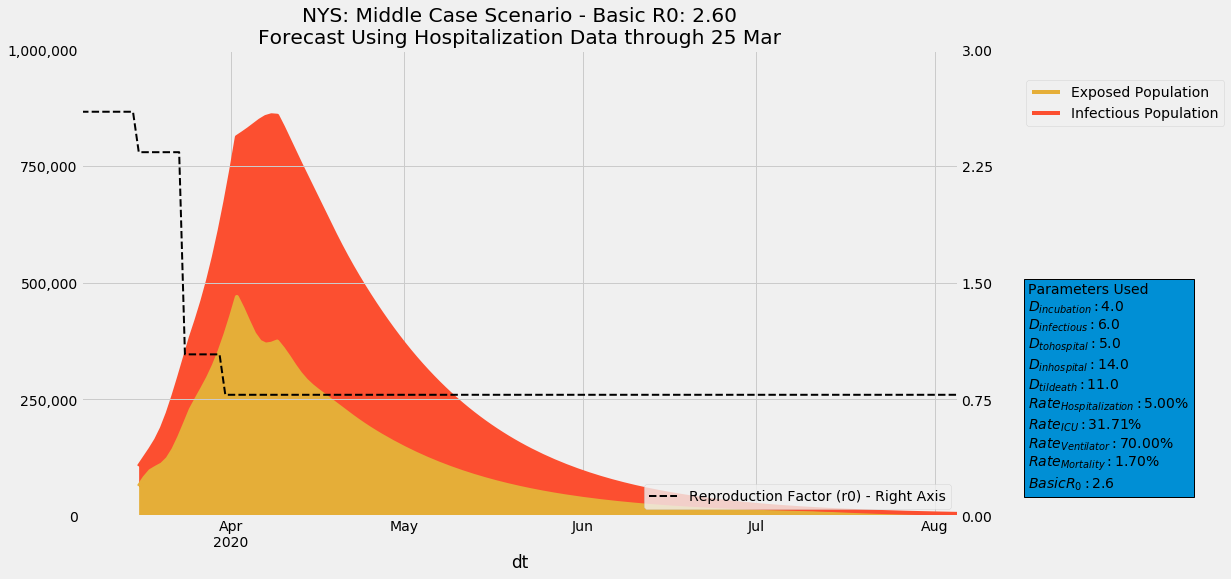

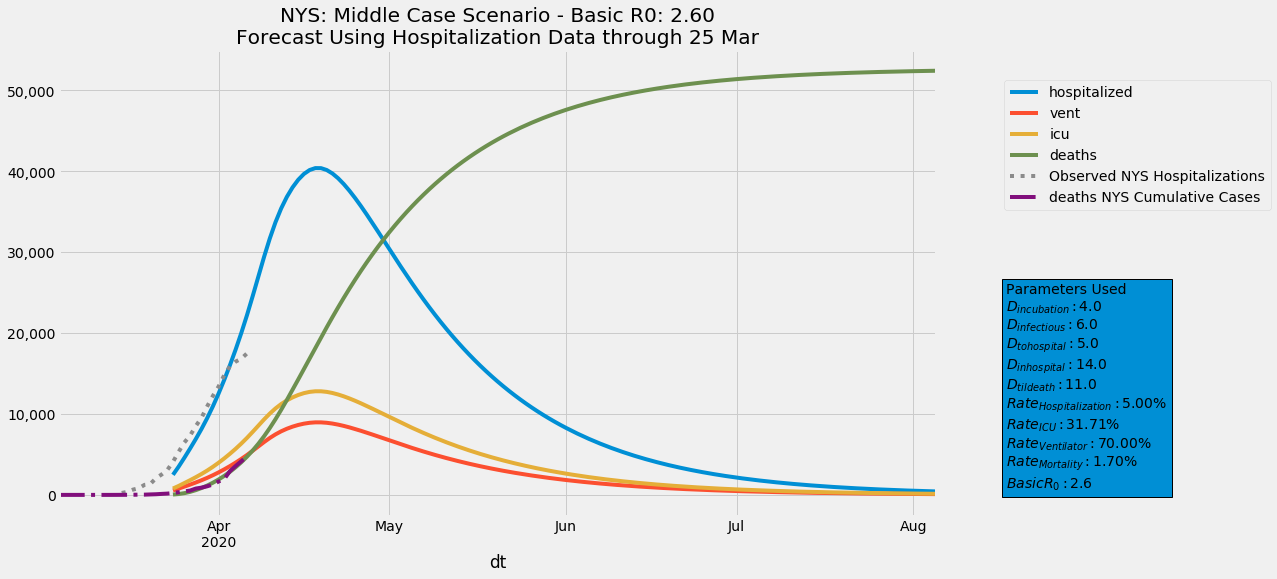

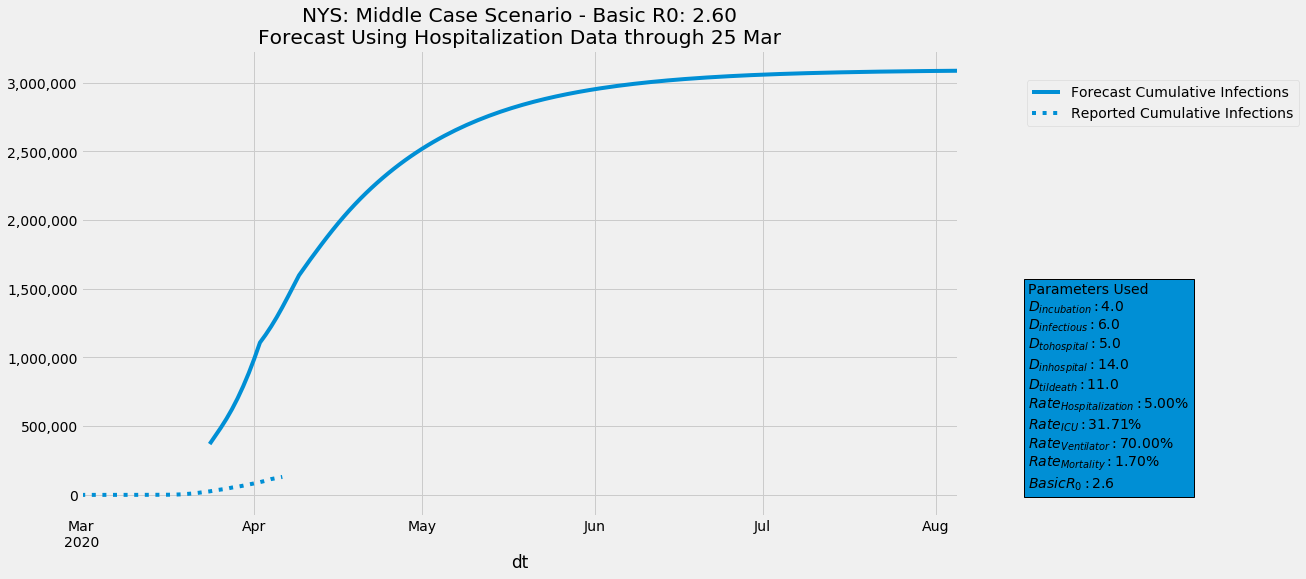

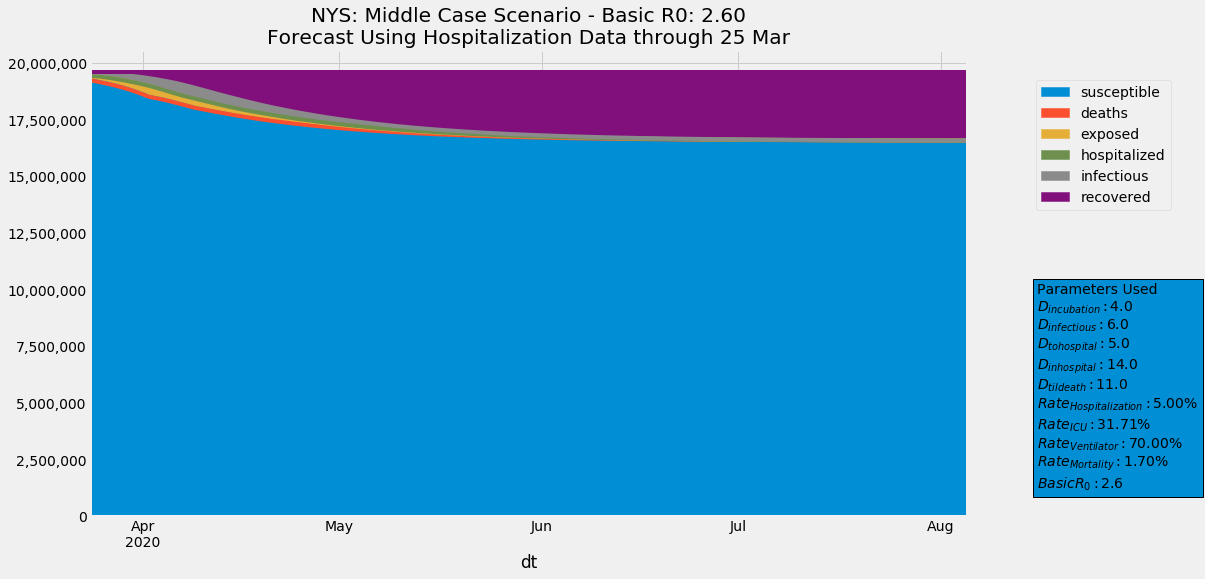

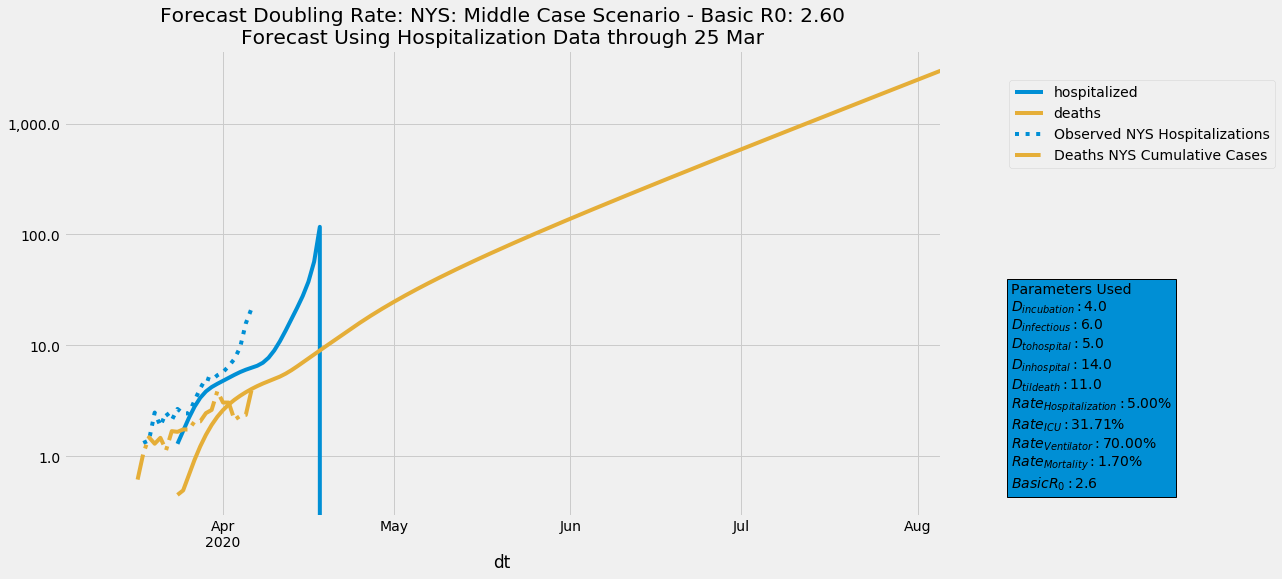

Peak Hospitalization Date:  18 Apr, 2020
Peak Hospitalization #: 40402
Peak ICU #: 12810
Peak Ventilator #: 8967


In [105]:
# Pre-intervention R0
basic_r0 = 2.6

# Scenario R0's. Within parentheses the first element should be the date when a policy starts. 
# The second element is the r0 value for that policy action. Policy actions should be separated by
# a comma.
r_dates = [('2020-03-16', basic_r0*.9), ('2020-03-24', basic_r0*.4), 
           ('2020-03-31',basic_r0*.3), ('2021-05-15', basic_r0*.7)]

# Scenario Name
scenario_name = "Middle Case"

df_agg, df_all_cohorts = run_cohort_model(
    d_to_forecast, curr_suspop, curr_hosp, exposed_pct, curr_recovered, curr_deaths, 
                 hosp_obs_dt, basic_r0, r_dates, 
                 d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt, 
                 d_til_death, d_in_hosp_mild, d_to_hosp, 
                 icu_rt, d_in_icu, vent_rt,
                 scenario_name, region_name, df_hosps, df_reporting_fmt)
df_scenarios[scenario_name] = df_agg.stack()


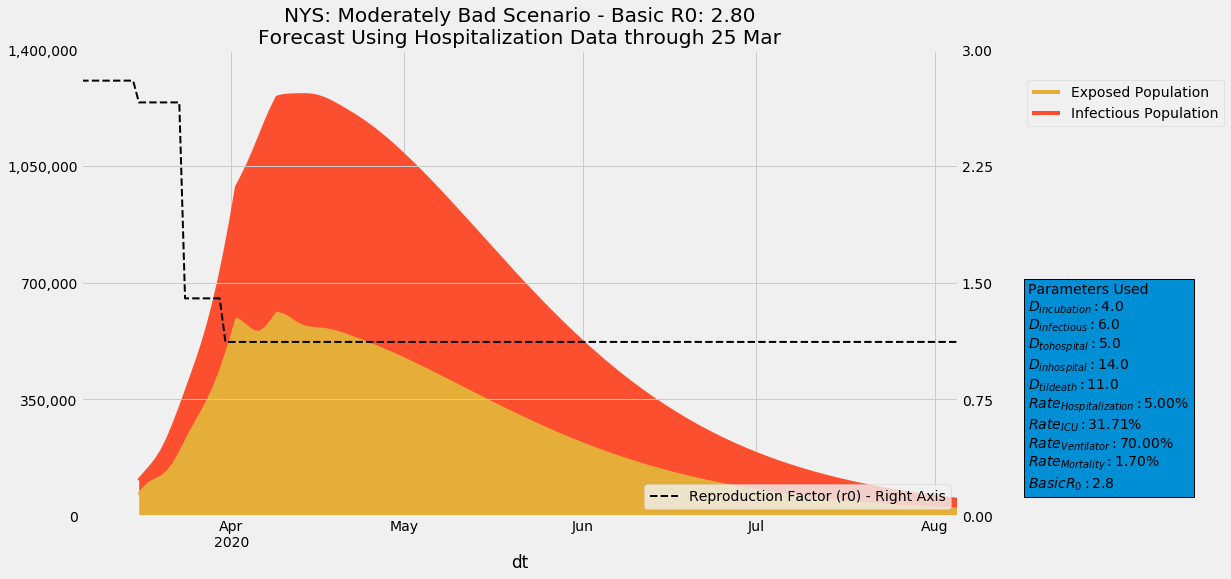

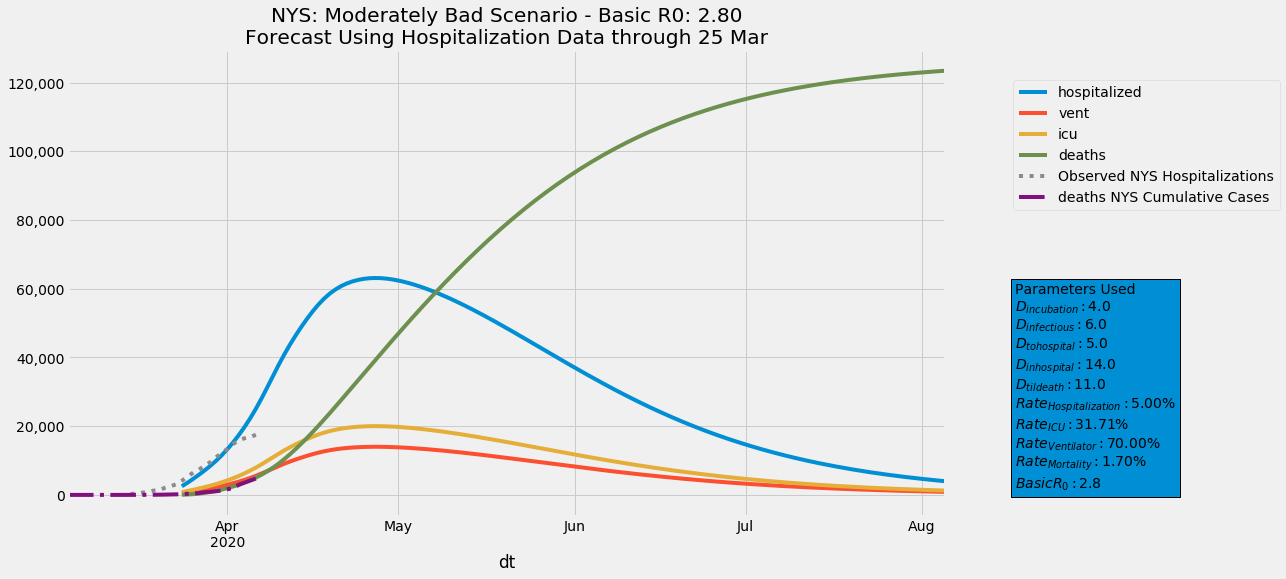

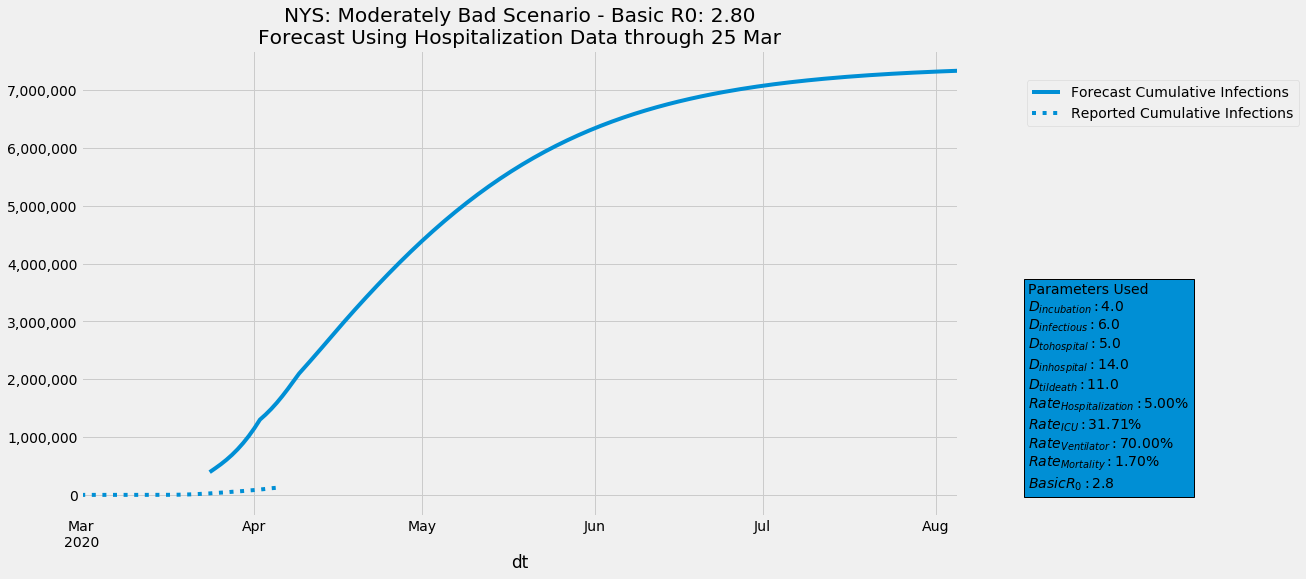

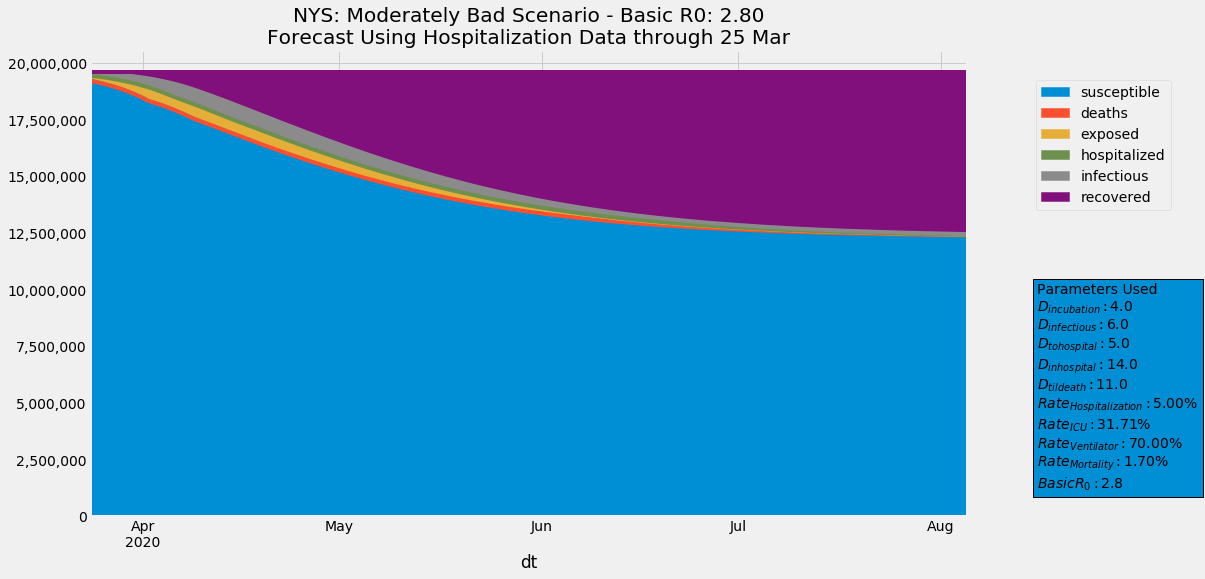

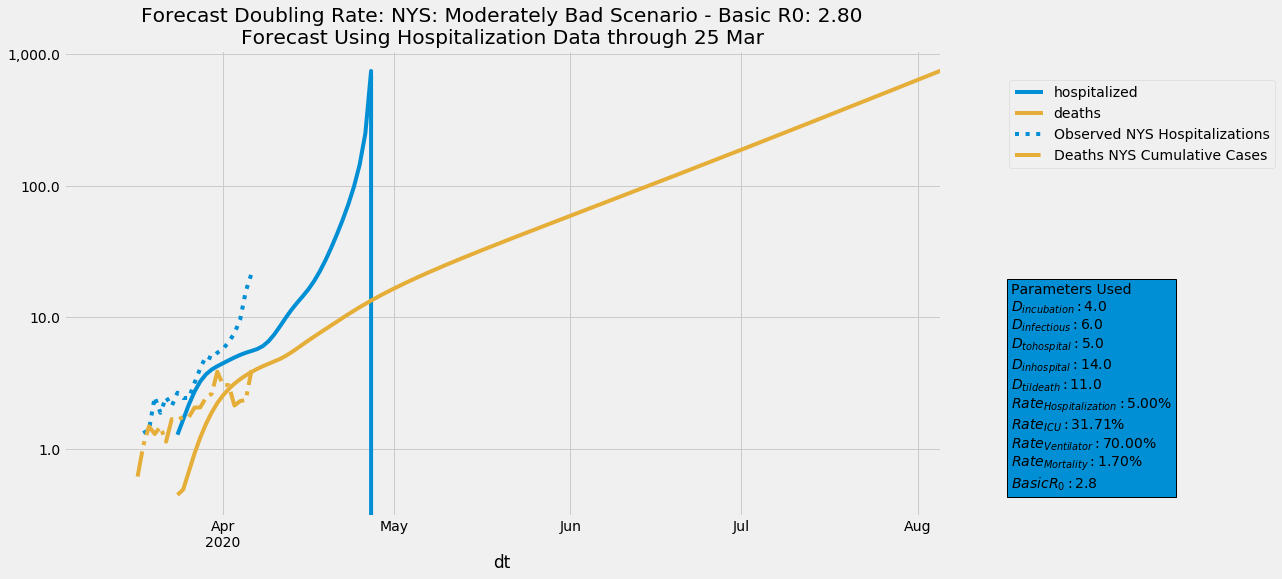

Peak Hospitalization Date:  27 Apr, 2020
Peak Hospitalization #: 63122
Peak ICU #: 20014
Peak Ventilator #: 14010


In [107]:
# Pre-intervention R0
basic_r0 = 2.8

# Scenario R0's. Within parentheses the first element should be the date when a policy starts. 
# The second element is the r0 value for that policy action. Policy actions should be separated by
# a comma.
r_dates = [('2020-03-16', basic_r0*.95), ('2020-03-24', basic_r0*.5), 
           ('2020-03-31',basic_r0*.4), ('2021-05-15', basic_r0*.8)]

# Scenario Name
scenario_name = "Moderately Bad"

df_agg, df_all_cohorts = run_cohort_model(
    d_to_forecast, curr_suspop, curr_hosp, exposed_pct, curr_recovered, curr_deaths, 
                 hosp_obs_dt, basic_r0, r_dates, 
                 d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt, 
                 d_til_death, d_in_hosp_mild, d_to_hosp, 
                 icu_rt, d_in_icu, vent_rt,
                 scenario_name, region_name, df_hosps, df_reporting_fmt)
df_scenarios[scenario_name] = df_agg.stack()


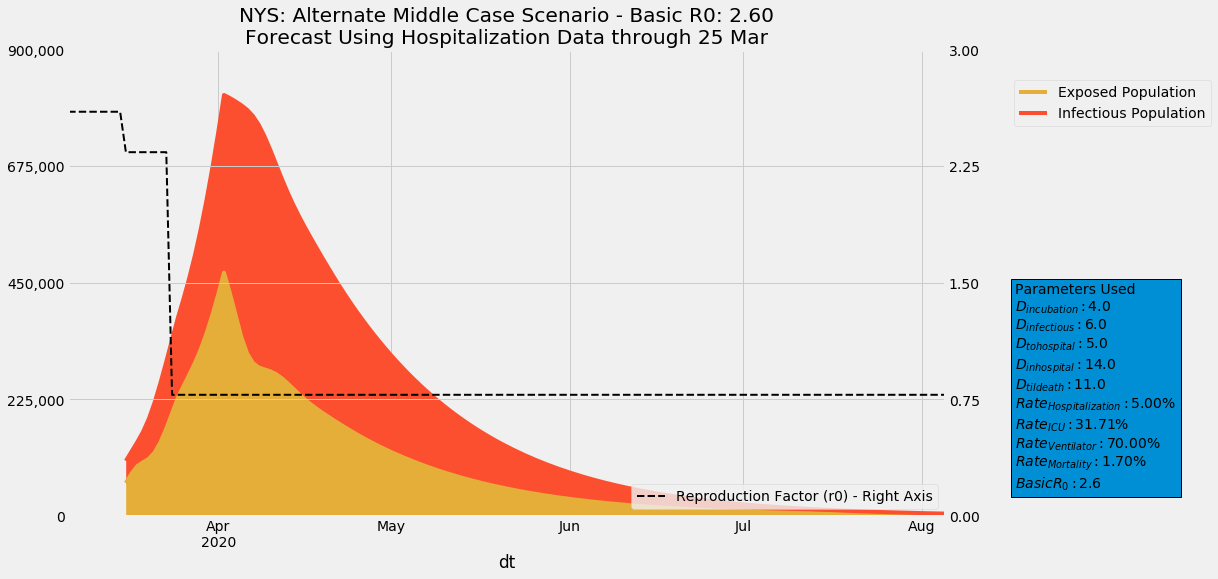

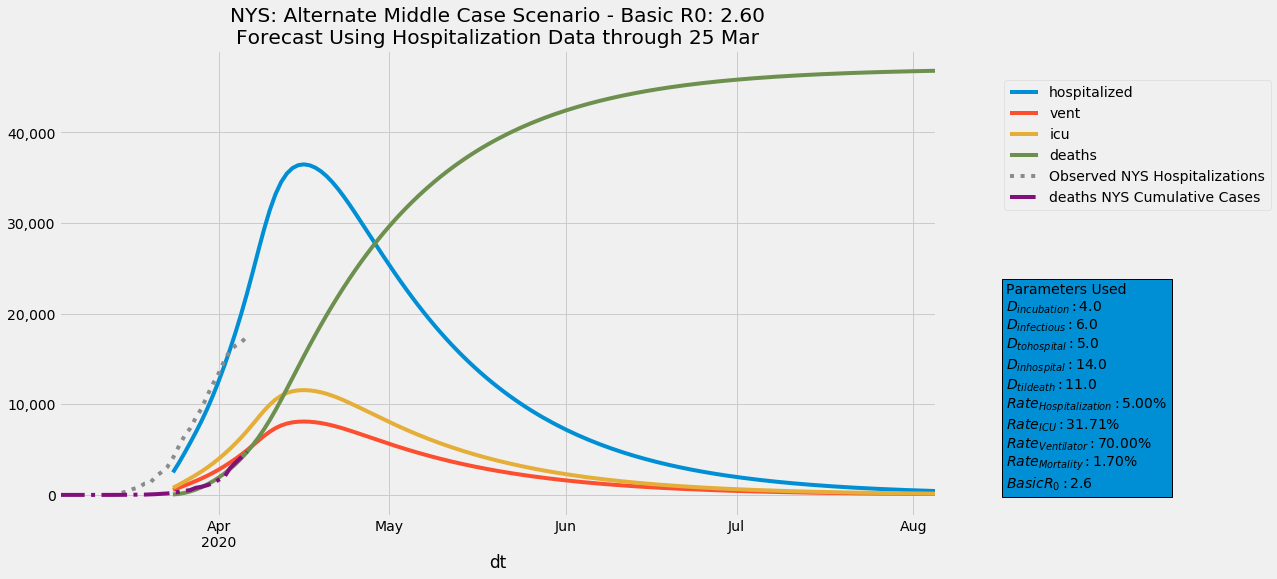

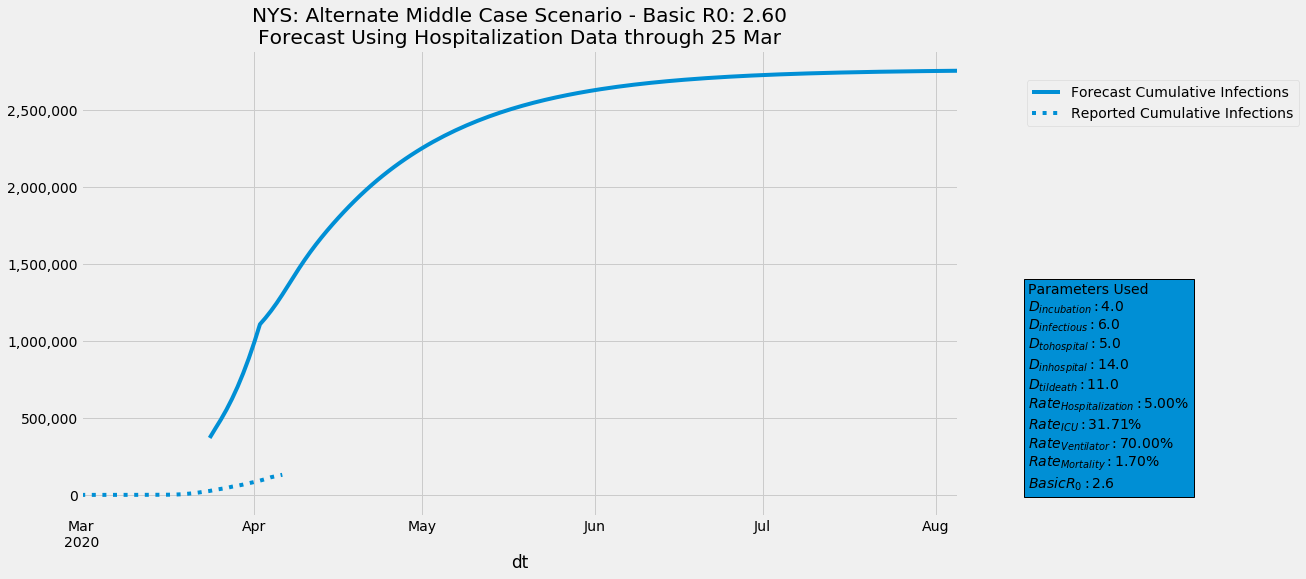

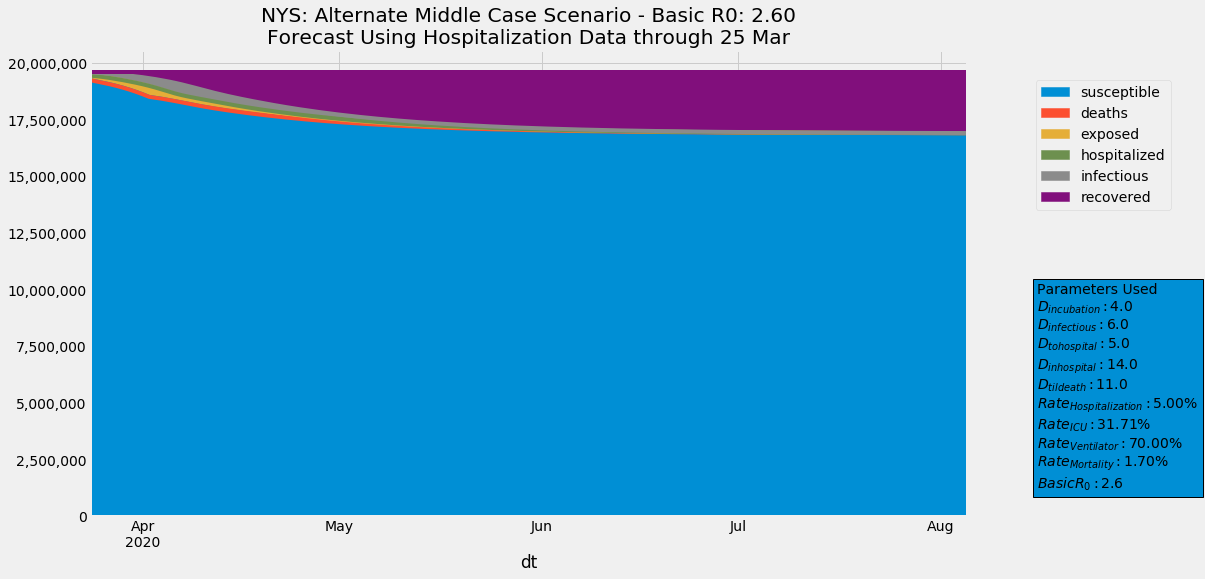

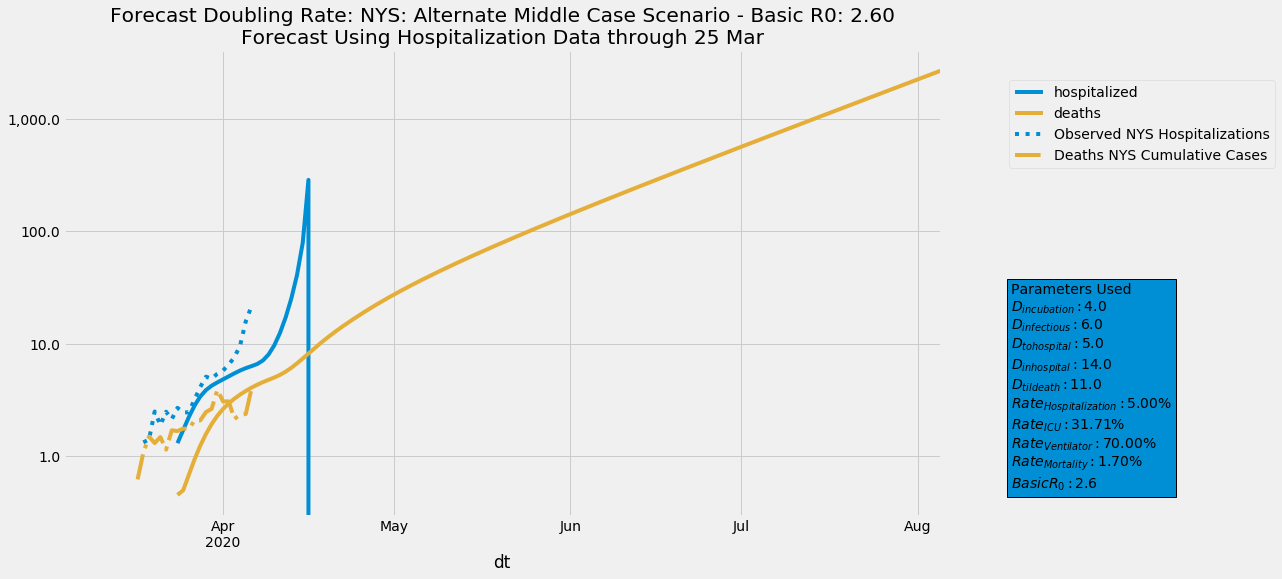

Peak Hospitalization Date:  16 Apr, 2020
Peak Hospitalization #: 36481
Peak ICU #: 11567
Peak Ventilator #: 8097


In [108]:
# Pre-intervention R0
basic_r0 = 2.6

# Scenario R0's. Within parentheses the first element should be the date when a policy starts. 
# The second element is the r0 value for that policy action. Policy actions should be separated by
# a comma.
r_dates = [('2020-03-16', basic_r0*.9), ('2020-03-24', basic_r0*.3), ('2021-05-15',basic_r0*.5)]

# Scenario Name
scenario_name = "Alternate Middle Case"

df_agg, df_all_cohorts = run_cohort_model(
    d_to_forecast, curr_suspop, curr_hosp, exposed_pct, curr_recovered, curr_deaths, 
                 hosp_obs_dt, basic_r0, r_dates, 
                 d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt, 
                 d_til_death, d_in_hosp_mild, d_to_hosp, 
                 icu_rt, d_in_icu, vent_rt,
                 scenario_name, region_name, df_hosps, df_reporting_fmt)
df_scenarios[scenario_name] = df_agg.stack()


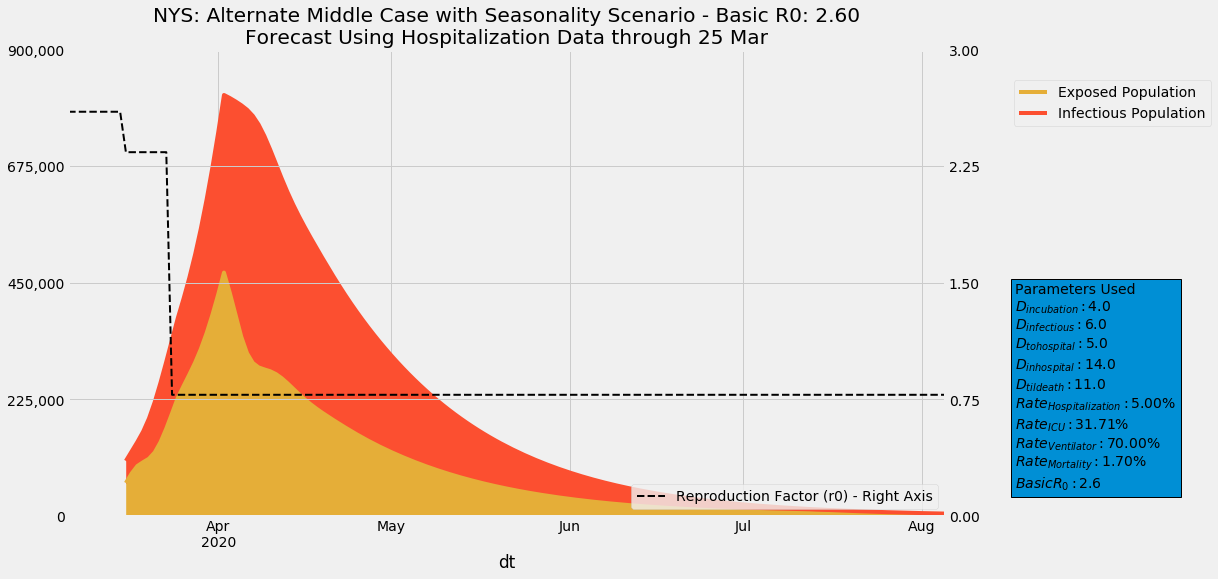

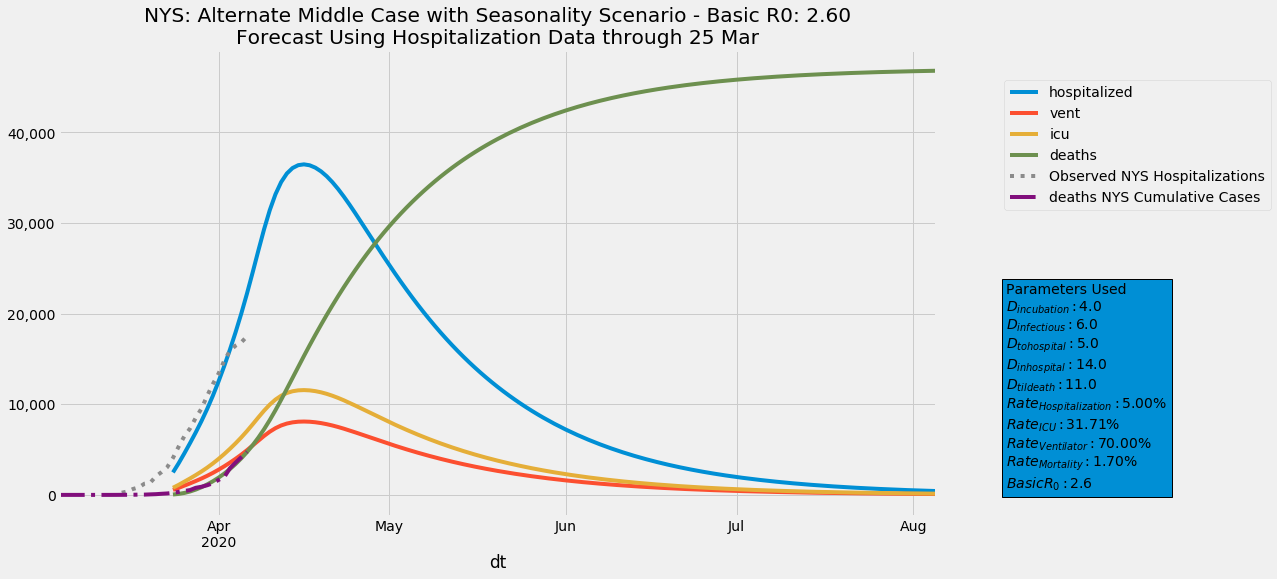

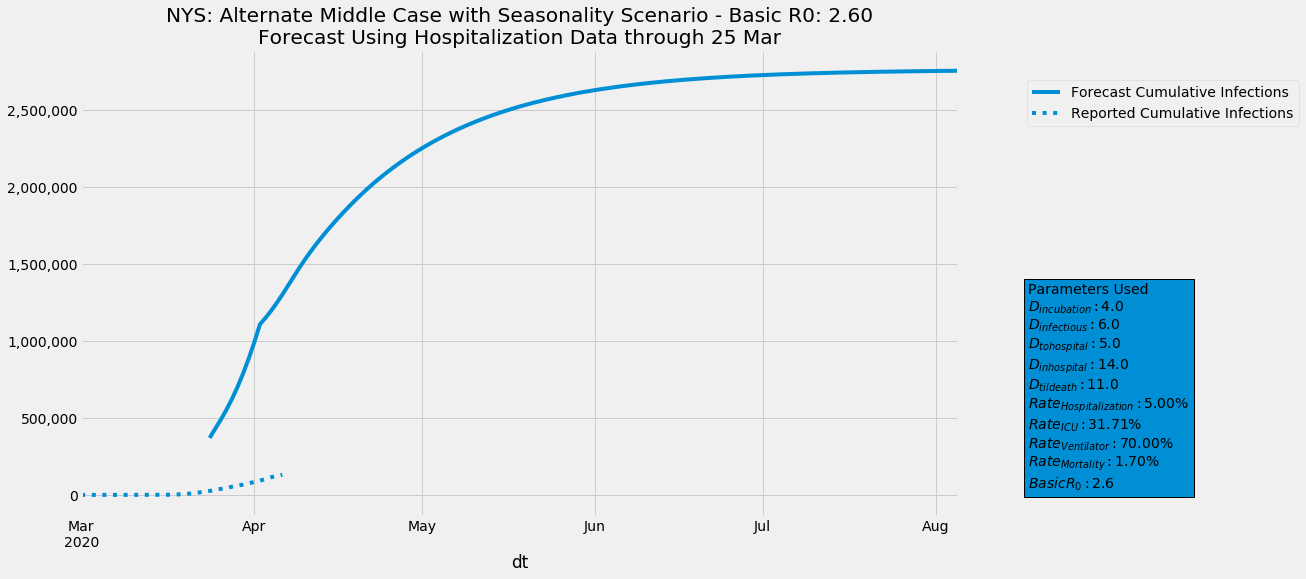

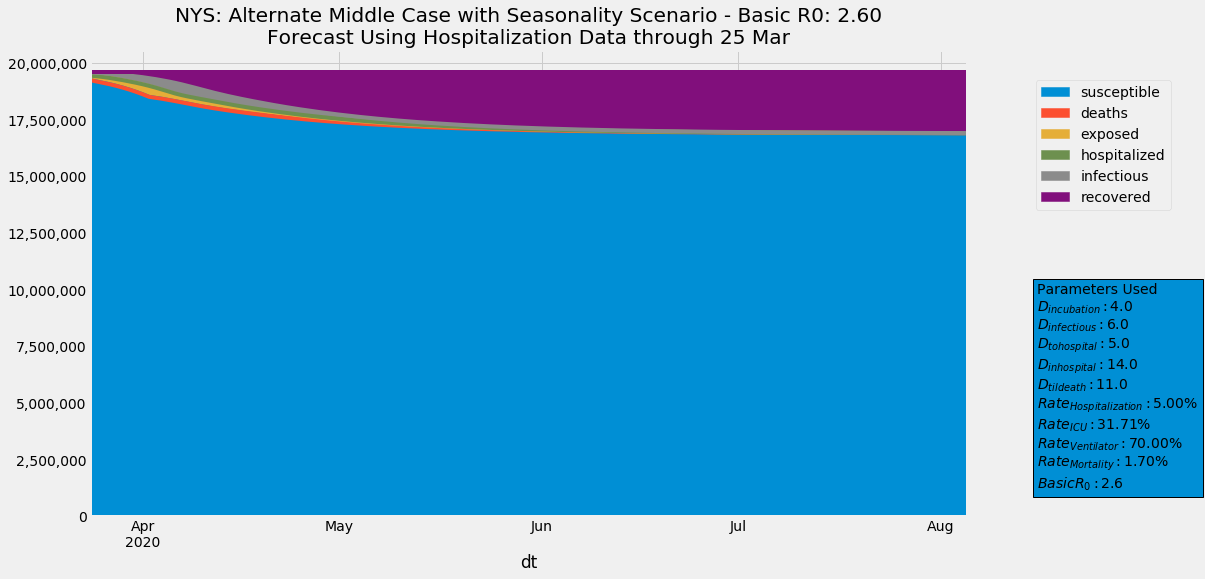

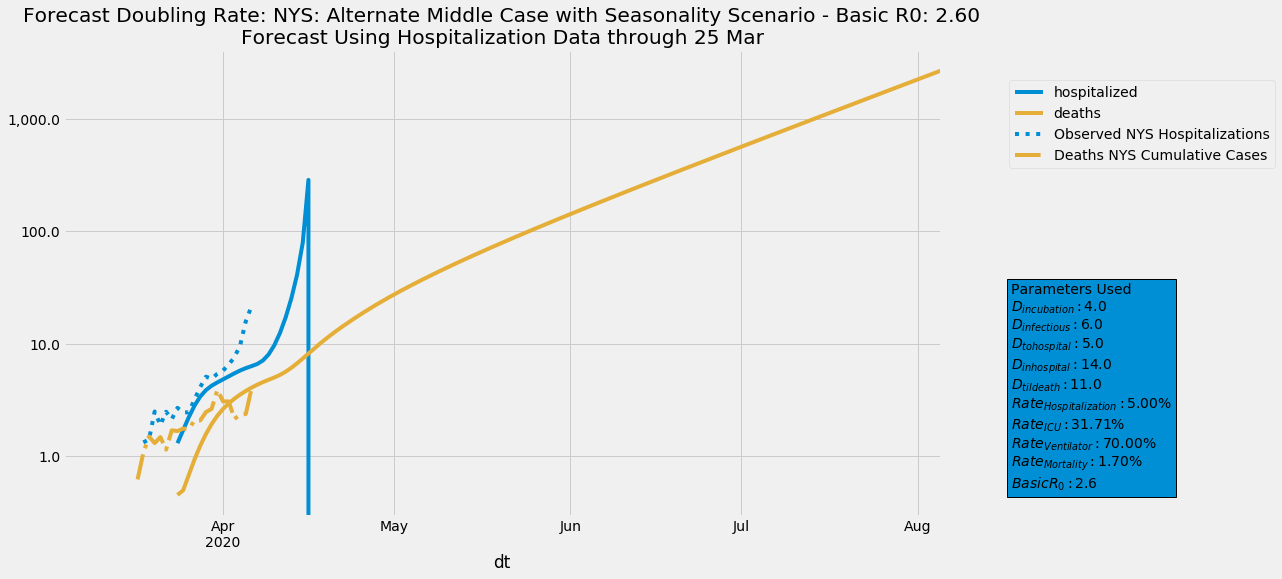

Peak Hospitalization Date:  16 Apr, 2020
Peak Hospitalization #: 36481
Peak ICU #: 11567
Peak Ventilator #: 8097


In [109]:
# Pre-intervention R0
basic_r0 = 2.6

# Scenario R0's. Within parentheses the first element should be the date when a policy starts. 
# The second element is the r0 value for that policy action. Policy actions should be separated by
# a comma.

r_dates = [('2020-03-16', basic_r0*.9), ('2020-03-24', basic_r0*.3), ('2021-05-15',basic_r0*.5*.8),
           ('2020-09-01', basic_r0*.5)]

# Scenario Name
scenario_name = "Alternate Middle Case with Seasonality"

df_agg, df_all_cohorts = run_cohort_model(
    d_to_forecast, curr_suspop, curr_hosp, exposed_pct, curr_recovered, curr_deaths, 
                 hosp_obs_dt, basic_r0, r_dates, 
                 d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt, 
                 d_til_death, d_in_hosp_mild, d_to_hosp, 
                 icu_rt, d_in_icu, vent_rt,
                 scenario_name, region_name, df_hosps, df_reporting_fmt)
df_scenarios[scenario_name] = df_agg.stack()


## Scenario Parameter Space Exploration

In [90]:
chart_col_dict = {'Citymapper Data Adjusted Reproduction Factor':'Activity Data-Based Forecast',
 'Good':'Optimistic Case', 'Middle Case':'Delayed-Effect Middle Case', 'Moderately Bad':'Bad Case',
       'Alternate Middle Case':'Middle Case'}

In [91]:
scenario_dict = {}

In [92]:
# ############# MODEL PARAMETERS #################
# # Total Population
# total_pop = 8e6 #19.6e6 #8e6 

# # Name of Region
# region_name = "NYC"

# hosp_obs_dt = pd.Timestamp('2020-03-31')#pd.Timestamp('2020-03-25')

# # Current Hospitalizations
# curr_hosp = df_hosps[region_name].loc[hosp_obs_dt]

# # Proportion of Total Infected/Exposed Population that is Exposed (i.e. not yet infectious)
# exposed_pct = .5 #.2

# # Total # of cases currently recovered/immune
# curr_recovered = 2000.

# # Number of days to forecast
# d_to_forecast = 200 #60

# # Days from exposure until symptoms (i.e. incubation period)
# d_incub=5.1 #4

# # Days after incubation period when infectious
# d_infect=5.

# # Mortality Rate
# mort_rt=.008

# # Average number of days in hospital for a hospitalized case
# d_in_hosp=14.

# # Hospitalization Rate of all infected people
# hosp_rt=.08

# # Days from end of incubation period until death for patients who die
# d_til_death=12.

# # Days from incubation period til arrival in hospital for all hospitalizations
# d_to_hosp=7. #11. #3. #7.

# # ICU rate as a proportion of all hospitalizations.
# icu_rt = 13./41. #Lancet Study Estimate
 
# # Ventilator rate as a proportion of all hospitalizations
# vent_rt = .7

# # [Currently not functional] Days in hospital for mild hospitalizations
# d_in_hosp_mild= 11. #NEJM Study Estimate

# # [Currently not functional] Days in hospital for ICU hospitalizations
# d_in_icu = 13. #NEJM Study Estimate

# # 8 Days Before Hospitalization Data, 
# # last_obs_dt = (hosp_obs_dt - pd.Timedelta(days=((d_incub+d_to_hosp)*1.))).round(freq='d')
# # print('implied last obs dt:', last_obs_dt)

# # Total # of deaths
# curr_deaths = df_reporting_fmt['deaths'][region_name].loc[hosp_obs_dt]

# # Susceptible Population
# curr_suspop = total_pop - curr_hosp/hosp_rt - curr_recovered - curr_deaths
# print('curr hosp obs dt: ', hosp_obs_dt)
# print('curr_hosp: ',curr_hosp)
# print('curr_deaths: ',curr_deaths)




# df_scenarios = pd.DataFrame()

# l_d_to_hosp = [3., 7., 11.]
# if len(l_d_to_hosp) > 1:
#     d_to_hosp = (min(l_d_to_hosp), max(l_d_to_hosp))
# else:
#     d_to_hosp = l_d_to_hosp[0]
    
# l_basic_r0 = [2.0, 3.0, 4.0, 5.0]
# if len(l_basic_r0) > 1:
#     basic_r0 = (min(l_basic_r0), max(l_basic_r0))
# else:
#     basic_r0 = l_basic_r0[0]
    
# param_str = param_str_maker(d_incub, d_infect, d_to_hosp, d_in_hosp, d_til_death,
#                 hosp_rt, icu_rt, vent_rt, mort_rt, basic_r0)

# for basic_r0 in l_basic_r0:
# #     entropy_rep_factor = 0.85
# #     entropy_lag_factor = int(d_incub+d_infect)

# #     adj_df_entropy = df_entropy.diff().mul(entropy_rep_factor).cumsum().add(
# #         df_entropy.iloc[0]).fillna(df_entropy.iloc[0])
# #     adj_df_entropy = adj_df_entropy.reindex(
# #         pd.date_range(adj_df_entropy.index[0],
# #                       adj_df_entropy.index[-1]+pd.Timedelta(days=entropy_lag_factor) ) )
# #     adj_df_entropy = adj_df_entropy.shift(entropy_lag_factor).fillna(method='bfill').clip(lower=0.01)
# # #     ax = adj_df_entropy['entropy_pct'].plot(label='adjusted movement', legend=True)
# # #     df_entropy['entropy_pct'].plot(ax = ax, label='movement', legend=True)
# # #     _ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
# # #     plt.show()

# #     # Scenario R0's. Within parentheses the first element should be the date when a policy starts. 
# #     # The second element is the r0 value for that policy action. Policy actions should be separated by
# #     # a comma.
# #     r_dates = list(adj_df_entropy.mul(basic_r0).itertuples(index=True))

# #     # Scenario Name
# #     scenario_name = 'Activity Data-Based Forecast'
# #     scenario_dict[scenario_name] = r_dates
#     # scenario_dict["Full Wuhan-Style Lockdown"] = [('2020-03-16', basic_r0*.9), ('2020-03-24', 0.33), ('2020-05-15',basic_r0*.75)]
#     scenario_dict['Optimistic Case'] = [('2020-03-16', basic_r0*.85), ('2020-03-24', basic_r0*.3), 
#                ('2020-03-31',basic_r0*.2), ('2020-05-15', basic_r0*.6)]
#     scenario_dict['Delayed-Effect Middle Case'] = [('2020-03-16', basic_r0*.9), ('2020-03-24', basic_r0*.4), 
#                ('2020-03-31',basic_r0*.3), ('2020-05-15', basic_r0*.7)]
#     scenario_dict['Moderately Bad Case'] = [('2020-03-16', basic_r0*.95), ('2020-03-24', basic_r0*.5), 
#                ('2020-03-31',basic_r0*.4), ('2020-05-15', basic_r0*.8)]
#     scenario_dict['Middle Case'] = [('2020-03-16', basic_r0*.9), ('2020-03-24', basic_r0*.3), ('2020-05-15',basic_r0*.5)]
#     scenario_dict["Middle Case with Seasonality"] = [('2020-03-16', basic_r0*.9), ('2020-03-24', basic_r0*.3), ('2020-05-15',basic_r0*.5*.8),
#                ('2020-09-01', basic_r0*.5)]
#     for d_to_hosp in l_d_to_hosp:
#         for scenario_name, r_dates in scenario_dict.items():
#             print(scenario_name, r_dates[0])
#             curr_exposed = curr_hosp/hosp_rt*exposed_pct
#             curr_infectious = curr_hosp/hosp_rt*(1-exposed_pct)
#             r_t = pd.Series(np.nan, index=pd.date_range(hosp_obs_dt - pd.Timedelta(days=int(d_incub+d_to_hosp)), 
#                                                         hosp_obs_dt + pd.Timedelta(days=d_to_forecast)))
#             pa_s = pd.DataFrame(r_dates)
#             pa_s = pa_s.set_index(pa_s.columns[0])[pa_s.columns[1]]
#             pa_s.index = pd.to_datetime(pa_s.index).normalize()
#             r_t.index = pd.DatetimeIndex(r_t.index).normalize()
#             r_t = r_t.fillna(pa_s)
#             if pd.isnull(r_t.iloc[0]):
#                 r_t.iloc[0] = basic_r0
#             r_t = r_t.fillna(method='ffill')
#             l_r_t = r_t.to_list()

#             df_agg, df_all_cohorts = seir_model_cohort(
#                 curr_suspop, curr_exposed, curr_infectious, 
#                 df_hosps[region_name][hosp_obs_dt - pd.Timedelta(days=int(d_incub+d_to_hosp))],
#                 curr_recovered, curr_deaths, hosp_obs_dt,
#                 l_r_t, d_incub, d_infect, d_to_forecast, mort_rt, d_in_hosp, 
#                 hosp_rt, d_til_death, d_in_hosp_mild, d_to_hosp,
#                 icu_rt, d_in_icu, vent_rt
#             ) 
#             df_scenarios[scenario_name+'_d2h'+str(int(d_to_hosp))+'_r0'+str(int(basic_r0)) ] = df_agg.stack()

In [93]:
# df_chart_all = df_scenarios.unstack().swaplevel(axis=1)
# for col in df_chart_all.columns.levels[0]:

#     df_chart = df_chart_all[col]
#     df_chart = df_chart.iloc[8:]

#     chart_title = "{0} {2} Scenarios\nForecast Using Hospitalization Data through {1}".format(
#             region_name, hosp_obs_dt.strftime("%d %b"), col.capitalize())

#     ax = df_chart.mean(axis=1).plot(label='Mean', legend=True)
#     ax = df_chart.median(axis=1).plot(label='Median', legend=True)

#     if col == 'hospitalized':
#         _ = df_hosps[region_name].plot(ax=ax, label='Reported Hospitalizations',
#                                       color='black', linestyle=':', legend=True)
#         plt.legend(['Mean of Forecasts','Median of Forecasts','Reported Hospitalizations'])
#     else:
#         plt.legend(['Mean of Forecasts','Median of Forecasts','Reported Hospitalizations'])
        
#     df_chart.plot(ax=ax, figsize=[14,8], title=chart_title, legend=False, 
#                        label=['_nolegend_']*72, alpha=.1)

#     _ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    

#     ax.text(1.08, 0.05, param_str, transform=ax.transAxes,
#         verticalalignment='bottom', bbox={'ec':'black','lw':1})
#     plt.show()

dt
2020-04-06    670.75
Name: NYS, dtype: float64


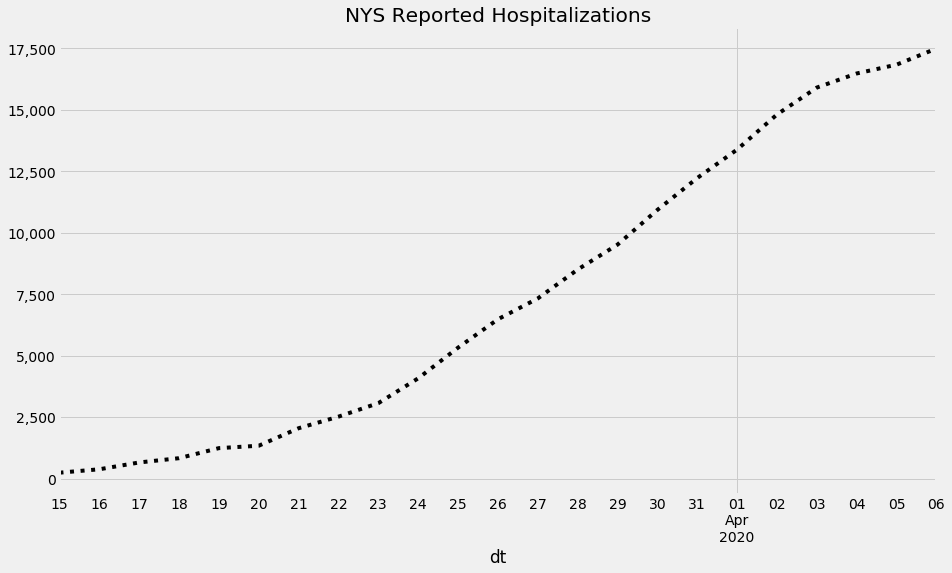

In [94]:
ax =df_hosps[region_name].dropna().plot(figsize=[14,8], color='black', linestyle=':',
                               title='{} Reported Hospitalizations'.format(region_name))

print(df_hosps[region_name].diff().rolling(4).mean().iloc[[-1]])
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# Explain Cohort Model

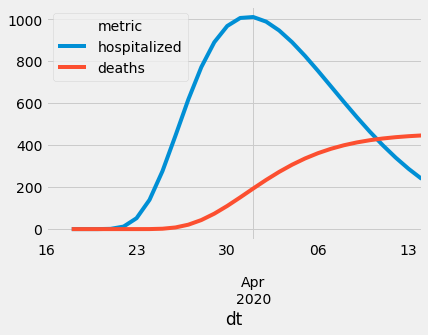

In [95]:
df_all_cohorts.iloc[:,2].unstack(1)[['hospitalized','deaths']].iloc[:30].plot()

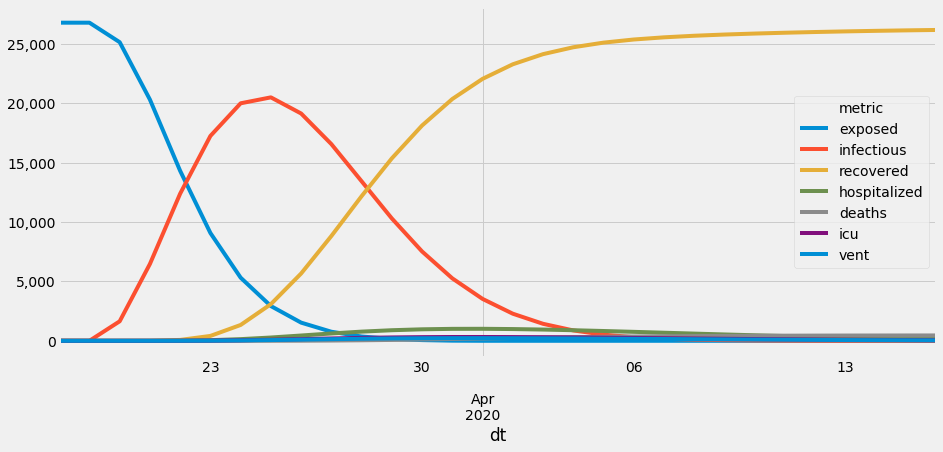

In [96]:
ax = df_all_cohorts.iloc[:,2].unstack().dropna().iloc[:30].plot(figsize=[14,6])
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()


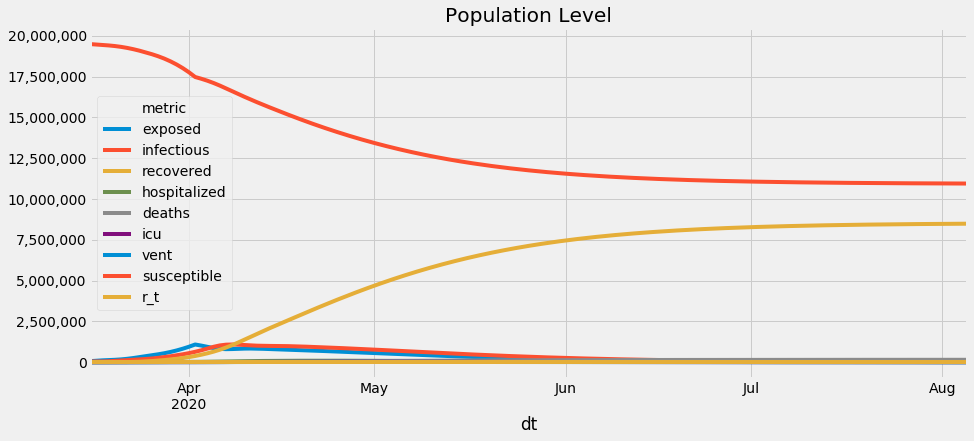

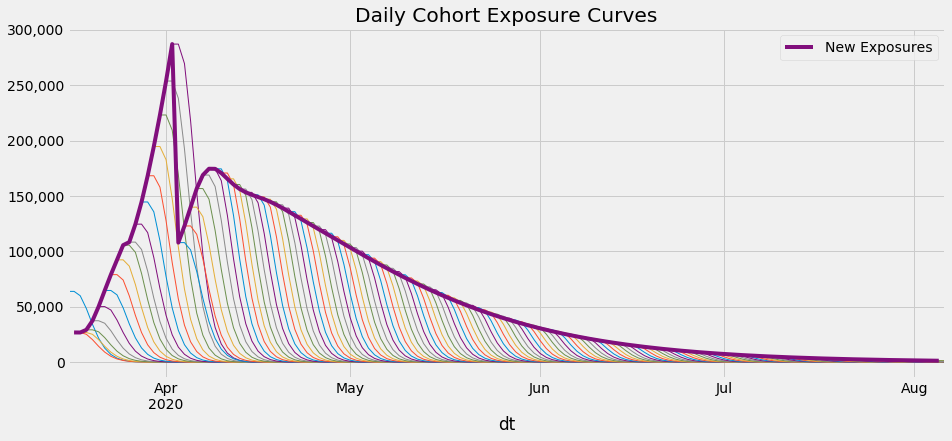

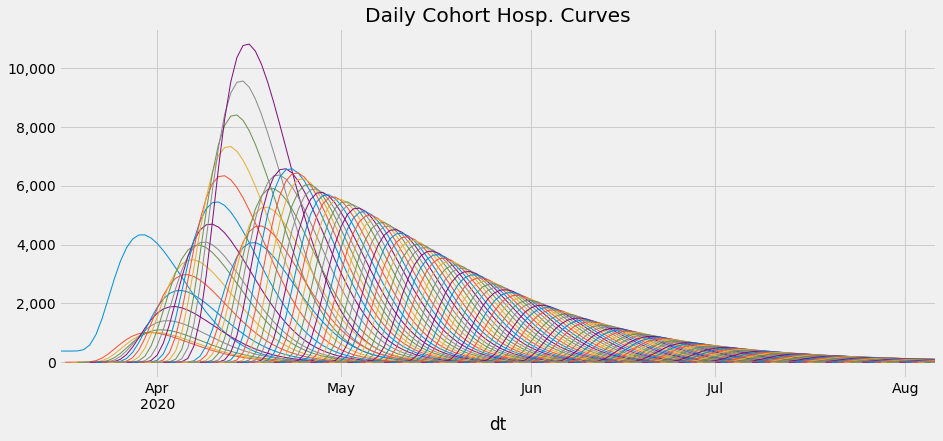

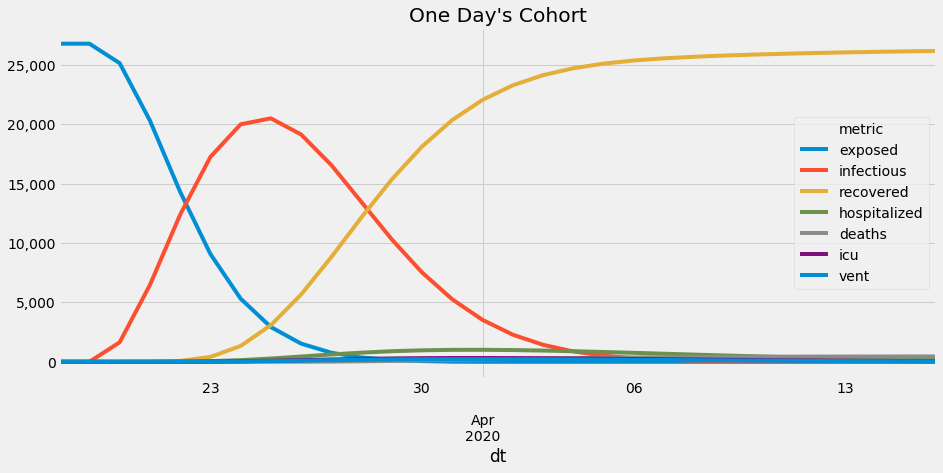

In [97]:
ax = df_agg.plot(label='Susceptible Population', legend=True,figsize=[14,6], title='Population Level')
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

ax = df_all_cohorts.unstack().swaplevel(axis=1)['exposed'].plot(legend=False, figsize=[14,6], 
                                                          linewidth=1, title='Daily Cohort Exposure Curves')
df_agg.susceptible.diff().mul(-1).plot(ax=ax, label='New Exposures', legend=True)
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

ax = df_all_cohorts.unstack().swaplevel(axis=1)['hospitalized'].plot(legend=False, figsize=[14,6], 
                                                          linewidth=1, title='Daily Cohort Hosp. Curves')
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

ax = df_all_cohorts.iloc[:,2].unstack().dropna().iloc[:30].plot(figsize=[14,6], title='One Day\'s Cohort')
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()


# Monte Carlo

In [98]:
# n_scenarios = 100
# region_name = 'NYS'
# df_mc_results = pd.DataFrame()
# df_mc_params = pd.DataFrame()

# for i in range(n_scenarios):
    
#     ############# MODEL PARAMETERS #################
#     # Total Population
#     total_pop = 19.6e6 #19.6e6 #8e6 

#     # Name of Region
#     region_name = "NYS"

#     hosp_obs_dt = pd.Timestamp('2020-04-04')

#     # Current Hospitalizations
#     curr_hosp = df_hosps[region_name].loc[hosp_obs_dt]

#     # Proportion of Total Infected/Exposed Population that is Exposed (i.e. not yet infectious)
#     exposed_pct = .5

#     # Total # of cases currently recovered/immune
#     curr_recovered = 2000.

#     # Number of days to forecast
#     d_to_forecast = 75

#     # Days from exposure until symptoms (i.e. incubation period)
#     d_incub = np.random.normal(4.5,0.5)

#     # Days after incubation period when infectious
#     d_infect=np.random.gamma(6,1)

#     # Mortality Rate
#     mort_rt=np.random.gamma(0.01,1)

#     # Average number of days in hospital for a hospitalized case
#     d_in_hosp=np.random.normal(11,2)

#     # Hospitalization Rate of all infected people
#     hosp_rt=np.random.normal(.075,0.015)

#     # Days from end of incubation period until death for patients who die
#     d_til_death=np.random.normal(12,2)

#     # Days from incubation period til arrival in hospital for all hospitalizations
#     d_to_hosp=np.random.normal(7,2.5) #11. #3. #7.

#     # ICU rate as a proportion of all hospitalizations.
#     icu_rt = np.random.normal(13./41.,0.02) #Lancet Study Estimate

#     # Ventilator rate as a proportion of all hospitalizations
#     vent_rt = np.random.normal(0.7,0.05)

#     # Total # of deaths
#     curr_deaths = df_reporting_fmt['deaths'][region_name].loc[hosp_obs_dt]

#     # Susceptible Population
#     curr_suspop = total_pop - curr_hosp/hosp_rt - curr_recovered - curr_deaths

    
    
#     r_t = est_r_t(df_hosps[region_name], 2, d_infect, d_incub+d_to_hosp)
#     basic_r0 = r_t.iloc[0]

#     mul_r_t = pd.Series((1+r_t.pct_change().rolling(5).mean().iloc[-1]), 
#                         index=pd.date_range(r_t.index[-1]+pd.Timedelta(days=1),
#                                         r_t.index[-1]+pd.Timedelta(days=d_to_forecast+d_incub+d_to_hosp)
#                                        )).cumprod()
#     fore_r_t = mul_r_t.mul(r_t.iloc[-1])
#     fore_r_t = pd.concat([r_t, fore_r_t])
#     r_dates = list(pd.DataFrame(fore_r_t).itertuples(index=True))
    
#     curr_exposed = curr_hosp/hosp_rt*exposed_pct
#     curr_infectious = curr_hosp/hosp_rt*(1-exposed_pct)
#     r_t = pd.Series(np.nan, index=pd.date_range(hosp_obs_dt - pd.Timedelta(days=int(d_incub+d_to_hosp)), 
#                                                 hosp_obs_dt + pd.Timedelta(days=d_to_forecast)))
#     pa_s = pd.DataFrame(r_dates)
#     pa_s = pa_s.set_index(pa_s.columns[0])[pa_s.columns[1]]
#     pa_s.index = pd.to_datetime(pa_s.index).normalize()
#     r_t.index = pd.DatetimeIndex(r_t.index).normalize()
#     r_t = r_t.fillna(pa_s)
#     if pd.isnull(r_t.iloc[0]):
#         r_t.iloc[0] = basic_r0
#     r_t = r_t.fillna(method='ffill')
#     l_r_t = r_t.to_list()
    
#     try:
#         df_agg, df_all_cohorts = seir_model_cohort(
#             curr_suspop, curr_exposed, curr_infectious, 
#             df_hosps[region_name][hosp_obs_dt - pd.Timedelta(days=int(d_incub+d_to_hosp))],
#             curr_recovered, curr_deaths, hosp_obs_dt,
#             l_r_t, d_incub, d_infect, d_to_forecast, mort_rt, d_in_hosp, 
#             hosp_rt, d_til_death, d_in_hosp_mild, d_to_hosp,
#             icu_rt, d_in_icu, vent_rt
#         ) 

#         df_mc_results[i] = df_agg.stack()
#     except:
#         pass
    

In [99]:
# ############# MODEL PARAMETERS #################
# # Total Population
# total_pop = 8e6 #19.6e6 #8e6 

# # Name of Region
# region_name = "NYC"

# hosp_obs_dt = pd.Timestamp('2020-03-31')#pd.Timestamp('2020-03-25')

# # Current Hospitalizations
# curr_hosp = df_hosps[region_name].loc[hosp_obs_dt]

# # Proportion of Total Infected/Exposed Population that is Exposed (i.e. not yet infectious)
# exposed_pct = .5 #.2

# # Total # of cases currently recovered/immune
# curr_recovered = 2000.

# # Number of days to forecast
# d_to_forecast = 200 #60

# # Days from exposure until symptoms (i.e. incubation period)
# d_incub=5.1 #4

# # Days after incubation period when infectious
# d_infect=5.

# # Mortality Rate
# mort_rt=.008

# # Average number of days in hospital for a hospitalized case
# d_in_hosp=14.

# # Hospitalization Rate of all infected people
# hosp_rt=.08

# # Days from end of incubation period until death for patients who die
# d_til_death=12.

# # Days from incubation period til arrival in hospital for all hospitalizations
# d_to_hosp=7. #11. #3. #7.

# # ICU rate as a proportion of all hospitalizations.
# icu_rt = 13./41. #Lancet Study Estimate
 
# # Ventilator rate as a proportion of all hospitalizations
# vent_rt = .7

# # [Currently not functional] Days in hospital for mild hospitalizations
# d_in_hosp_mild= 11. #NEJM Study Estimate

# # [Currently not functional] Days in hospital for ICU hospitalizations
# d_in_icu = 13. #NEJM Study Estimate

# # 8 Days Before Hospitalization Data, 
# # last_obs_dt = (hosp_obs_dt - pd.Timedelta(days=((d_incub+d_to_hosp)*1.))).round(freq='d')
# # print('implied last obs dt:', last_obs_dt)

# # Total # of deaths
# curr_deaths = df_reporting_fmt['deaths'][region_name].loc[hosp_obs_dt]

# # Susceptible Population
# curr_suspop = total_pop - curr_hosp/hosp_rt - curr_recovered - curr_deaths

In [100]:
# from sklearn.metrics import mean_squared_error
# from scipy.optimize import minimize

# def min_err_mod(x_inputs,d_to_hosp, d_infect, d_incub, df_hosps, region_name, curr_suspop, curr_recovered, curr_deaths,
#                 hosp_obs_dt, mort_rt, d_in_hosp, hosp_rt, d_til_death, d_in_hosp_mild, 
#                 icu_rt, d_in_icu, vent_rt, d_to_forecast):
    
#     offset_days, = x_inputs
#     print(x_inputs)
    
#     r_t = est_r_t(df_hosps[region_name], 3, d_infect, offset_days*d_to_hosp)
#     basic_r0 = r_t.iloc[0]

#     mul_r_t = pd.Series((1+r_t.pct_change().rolling(5).mean().iloc[-1]), 
#                         index=pd.date_range(r_t.index[-1]+pd.Timedelta(days=1),
#                                         r_t.index[-1]+pd.Timedelta(days=d_to_forecast+d_incub+d_to_hosp)
#                                        )).cumprod()
#     fore_r_t = mul_r_t.mul(r_t.iloc[-1])
#     fore_r_t = pd.concat([r_t, fore_r_t])
#     r_dates = list(pd.DataFrame(fore_r_t).itertuples(index=True))
    
#     curr_exposed = curr_hosp/hosp_rt*exposed_pct
#     curr_infectious = curr_hosp/hosp_rt*(1-exposed_pct)
#     r_t = pd.Series(np.nan, index=pd.date_range(hosp_obs_dt - pd.Timedelta(days=int(d_incub+d_to_hosp)), 
#                                                 hosp_obs_dt + pd.Timedelta(days=d_to_forecast+100)))
#     pa_s = pd.DataFrame(r_dates)
#     pa_s = pa_s.set_index(pa_s.columns[0])[pa_s.columns[1]]
#     pa_s.index = pd.to_datetime(pa_s.index).normalize()
#     r_t.index = pd.DatetimeIndex(r_t.index).normalize()
#     r_t = r_t.fillna(pa_s)
#     if pd.isnull(r_t.iloc[0]):
#         r_t.iloc[0] = basic_r0
#     r_t = r_t.fillna(method='ffill')
#     l_r_t = r_t.to_list()

#     df_agg, df_all_cohorts = seir_model_cohort(
#                 curr_suspop, curr_exposed, curr_infectious, 
#         df_hosps[region_name][hosp_obs_dt - pd.Timedelta(days=int(d_incub+d_to_hosp))]
#         curr_recovered, curr_deaths, hosp_obs_dt,
#                 l_r_t, d_incub, d_infect, d_to_forecast, mort_rt, d_in_hosp, 
#                 hosp_rt, d_til_death, d_in_hosp_mild, d_to_hosp,
#                 icu_rt, d_in_icu, vent_rt
#             ) 
    
#     overlap_idx = df_agg.hospitalized.dropna().iloc[int(d_incub+d_to_hosp):
#                                                    ].index.intersection(df_hosps[region_name].dropna().index)
#     mse = mean_squared_error(df_agg.loc[overlap_idx,'hospitalized'], df_hosps[region_name].loc[overlap_idx])
#     print(mse)
#     return mse

In [101]:
# res = minimize(min_err_mod, (1.), 
#                args = (d_to_hosp, d_infect, d_incub, df_hosps, region_name, 
#                        curr_suspop, curr_recovered, curr_deaths,
#                 hosp_obs_dt, mort_rt, d_in_hosp, hosp_rt, d_til_death, d_in_hosp_mild, 
#                 icu_rt, d_in_icu, vent_rt, 25), options={'maxiter':10}, tol=1e-5)